In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score,precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Understanding the Data

This data is a Home Equity Line of Credit dataset used to predict if a potential borrower will default on their loan based on historical data.

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

# 2. Read in the Data

In [3]:
df = pd.read_csv('data/heloc_dataset_v1.csv', sep = ',')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,3,5,23,1,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,0,8,7,0,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,7,8,9,4,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,6,6,30,3,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,7,8,12,0,25,0,1,1,51,89,3,1,0,80


# 3. Understanding Features

In [6]:
df.columns

Index(['RiskPerformance', 'ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance'],
      dtype='object')

These columns make sense. Standard metrics. The banking industry requires strong data if a bank is going to make determinations in addition to External Risk Estimate... which is your standard credit rating from a third party provider such as Experian etc.

<b>RiskPerformance:</b> Indicates the performance of the borrower in terms of loan repayment. 

<b>ExternalRiskEstimate:</b> An external estimate from another financial entity that predicts the probability of a borrower becoming past due in a certain time period.

<b>MSinceOldestTradeOpen:</b> The number of months since the borrower's oldest credit trade was opened.

<b>MSinceMostRecentTradeOpen:</b> The number of months since the borrower's most recent trade was opened.

<b>AverageMInFile:</b> Average number of months that the trades have been on file (or reported) for a specific borrower.

<b>NumSatisfactoryTrades:</b> The number of trades that are currently in "satisfactory" status.

<b>NumTrades60Ever2DerogPubRec:</b> The number of trades that have ever been 60 days or more delinquent or that led to a derogatory public record.

<b>NumTrades90Ever2DerogPubRec:</b> The number of trades that have ever been 90 days or more delinquent or that led to a derogatory public record.

<b>PercentTradesNeverDelq:</b> The percentage of all trades that have never been delinquent.

<b>MSinceMostRecentDelq:</b> Number of months since the most recent delinquency.

<b>MaxDelq2PublicRecLast12M:</b> The worst delinquency or public record in the last 12 months.

<b>MaxDelqEver:</b> The worst delinquency status the borrower has ever had.

<b>NumTotalTrades:</b> Total number of trades on the borrower's credit file.

<b>NumTradesOpeninLast12M:</b> Number of trades that were opened in the last 12 months.

<b>PercentInstallTrades:</b> Percentage of all trades that are installment trades.

<b>MSinceMostRecentInqexcl7days:</b> Months since the most recent inquiry, excluding the last 7 days.

<b>NumInqLast6M:</b> Number of inquiries on the borrower's credit file in the last 6 months.

<b>NumInqLast6Mexcl7days:</b> Number of inquiries on the borrower's credit file in the last 6 months, excluding the last 7 days.

<b>NetFractionRevolvingBurden:</b> This typically indicates the proportion of revolving trades  with a balance.

<b>NetFractionInstallBurden:</b> Similar to the above, but for installment trades.

<b>NumRevolvingTradesWBalance:</b> Number of revolving trades with a balance.

<b>NumInstallTradesWBalance:</b> Number of installment trades with a balance.

<b>NumBank2NatlTradesWHighUtilization:</b> Number of bank/national trades with high utilization.

<b>PercentTradesWBalance:</b> The percentage of all trades that currently have a balance.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   RiskPerformance                     10459 non-null  object
 1   ExternalRiskEstimate                10459 non-null  int64 
 2   MSinceOldestTradeOpen               10459 non-null  int64 
 3   MSinceMostRecentTradeOpen           10459 non-null  int64 
 4   AverageMInFile                      10459 non-null  int64 
 5   NumSatisfactoryTrades               10459 non-null  int64 
 6   NumTrades60Ever2DerogPubRec         10459 non-null  int64 
 7   NumTrades90Ever2DerogPubRec         10459 non-null  int64 
 8   PercentTradesNeverDelq              10459 non-null  int64 
 9   MSinceMostRecentDelq                10459 non-null  int64 
 10  MaxDelq2PublicRecLast12M            10459 non-null  int64 
 11  MaxDelqEver                         10459 non-null  in

All the data are integers. It was used for a FICO competition by real life machine learning engineerings from many banks accross the world. I am looking forward to taking a stab at this dataset.

In [8]:
# Displaying the unique values and count of those values.
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) > 10:  
        print(column, ":", unique_values[:10], "... and", len(unique_values) - 10, "more.")
    else:
        print(column, ":", unique_values)

RiskPerformance : ['Bad' 'Good']
ExternalRiskEstimate : [55 61 67 66 81 59 54 68 82 50] ... and 51 more.
MSinceOldestTradeOpen : [144  58  66 169 333 137  88 148 324  79] ... and 516 more.
MSinceMostRecentTradeOpen : [ 4 15  5  1 27 11  7  2 25  6] ... and 102 more.
AverageMInFile : [ 84  41  24  73 132  78  37  65 138  36] ... and 227 more.
NumSatisfactoryTrades : [20  2  9 28 12 31 25 17 24 19] ... and 64 more.
NumTrades60Ever2DerogPubRec : [ 3  4  0  1  2 -9  7  5 12  6] ... and 9 more.
NumTrades90Ever2DerogPubRec : [ 0  4  1  2  3 -9  5  9  7  6] ... and 7 more.
PercentTradesNeverDelq : [ 83 100  93  91  92  85  95  60  75  97] ... and 62 more.
MSinceMostRecentDelq : [ 2 -7 76  1  9 31  5 27 32  0] ... and 77 more.
MaxDelq2PublicRecLast12M : [ 3  0  7  6  4  5 -9  9  1  2]
MaxDelqEver : [ 5  8  6  4  2 -9  3  7]
NumTotalTrades : [23  7  9 30 12 32 26 18 27 19] ... and 78 more.
NumTradesOpeninLast12M : [ 1  0  4  3  2  5 -9  8  6  7] ... and 9 more.
PercentInstallTrades : [43 67 44 

### Plotting the Features

#### Risk Performance

In [9]:
risk_counts = df['RiskPerformance'].value_counts()

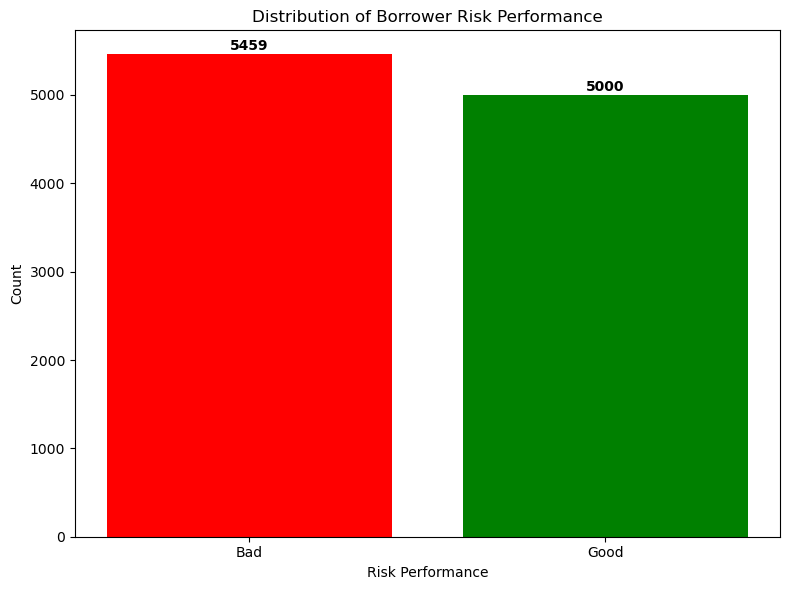

In [10]:
# Plotting a bar chart of good vs bad and their counts.
plt.figure(figsize=(8, 6))
bars = plt.bar(risk_counts.index, risk_counts.values, color=['red', 'green'])
plt.xlabel('Risk Performance')
plt.ylabel('Count')
plt.title('Distribution of Borrower Risk Performance')
plt.xticks(rotation=0) 

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, round(yval, 2), ha='center', color='black', fontweight='bold')

plt.tight_layout()  
plt.show()

Almost equal distribution. We will create a baseline model from this data so we understand how much better the models we create are than just guessing the rate of the data itself.

#### External Risk Assessment

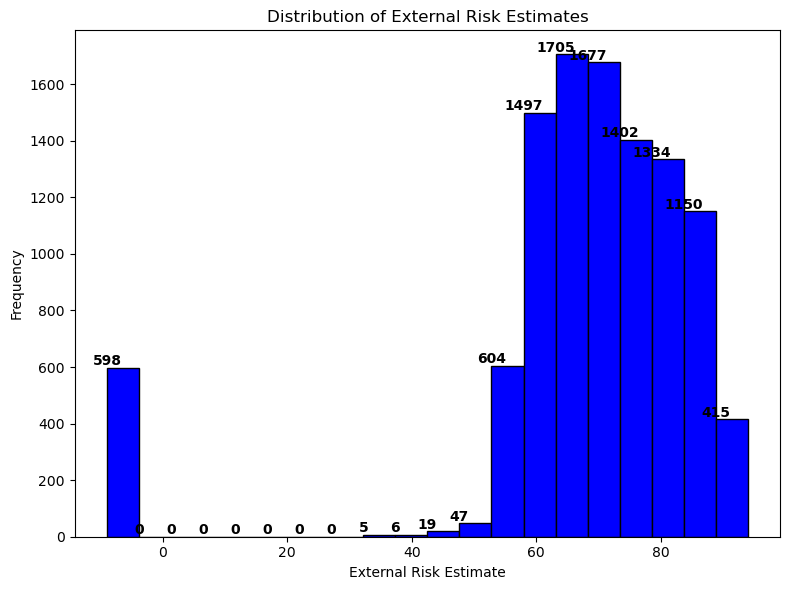

In [11]:
#Plotting distributions of external risk assessment feature.
plt.figure(figsize=(8, 6))
hist, bins, _ = plt.hist(df['ExternalRiskEstimate'], bins=20, color='blue', edgecolor='black')
plt.xlabel('External Risk Estimate')
plt.ylabel('Frequency')
plt.title('Distribution of External Risk Estimates')
plt.tight_layout() 


for bin_val, freq in zip(bins, hist):
    plt.text(bin_val, freq + 10, int(freq), ha='center', color='black', fontweight='bold')

plt.show()

Seems as though an external risk assessment below 50 is almost non-existent. There are 598 records that do not have an external risk estimate. Remember, this is not mandatory for creditors to utilize and when solely used, it has the highest requirement of captial to retain when distributing this. According to the Basel Accord II, creditors have to keep 75% of captial when they are solely utilizing External Risk Estimates. Therefore, good that we are modeling this so that our bank can make the most profit by reducing our probability of defaulting and therefore reducing our expected loss. In addition, if we model this with more sophisticated methods than just using an external risk estimate, we can garner more loans since we won't have to retain as much captial. On the flip side, we will have to explain our models to regulators very well. 

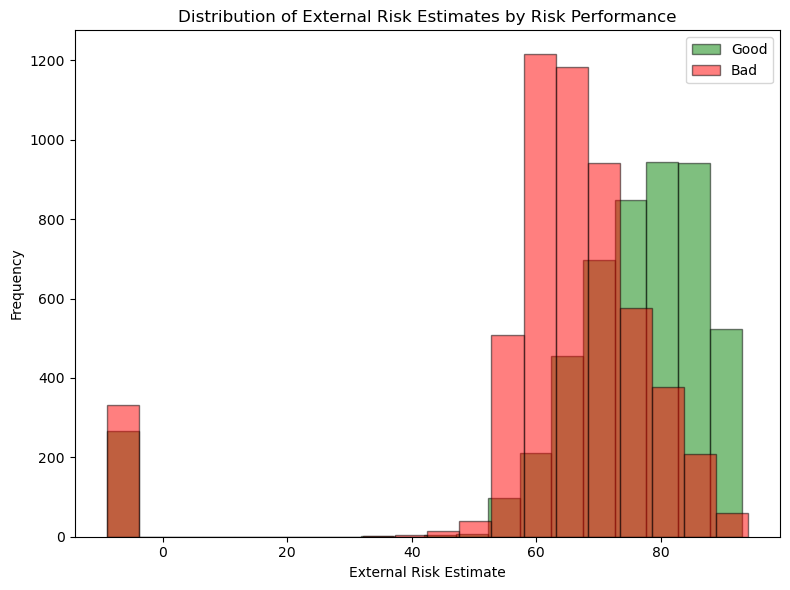

In [12]:
#Plotting external risk assessment by good and bad results.
plt.figure(figsize=(8, 6))
plt.hist(df[df['RiskPerformance'] == 'Good']['ExternalRiskEstimate'], bins=20, alpha=0.5, label='Good', color='green', edgecolor='black')
plt.hist(df[df['RiskPerformance'] == 'Bad']['ExternalRiskEstimate'], bins=20, alpha=0.5, label='Bad', color='red', edgecolor='black')
plt.xlabel('External Risk Estimate')
plt.ylabel('Frequency')
plt.title('Distribution of External Risk Estimates by Risk Performance')
plt.legend()
plt.tight_layout()
plt.show()

We can see here there is a clear performance of Bad when the external risk assessment is lower, and more good performance when the external risk assessment is better.

#### MSinceOldestTradeOpen, MSinceMostRecentTradeOpen, & AverageMInFile (Time Based Features)

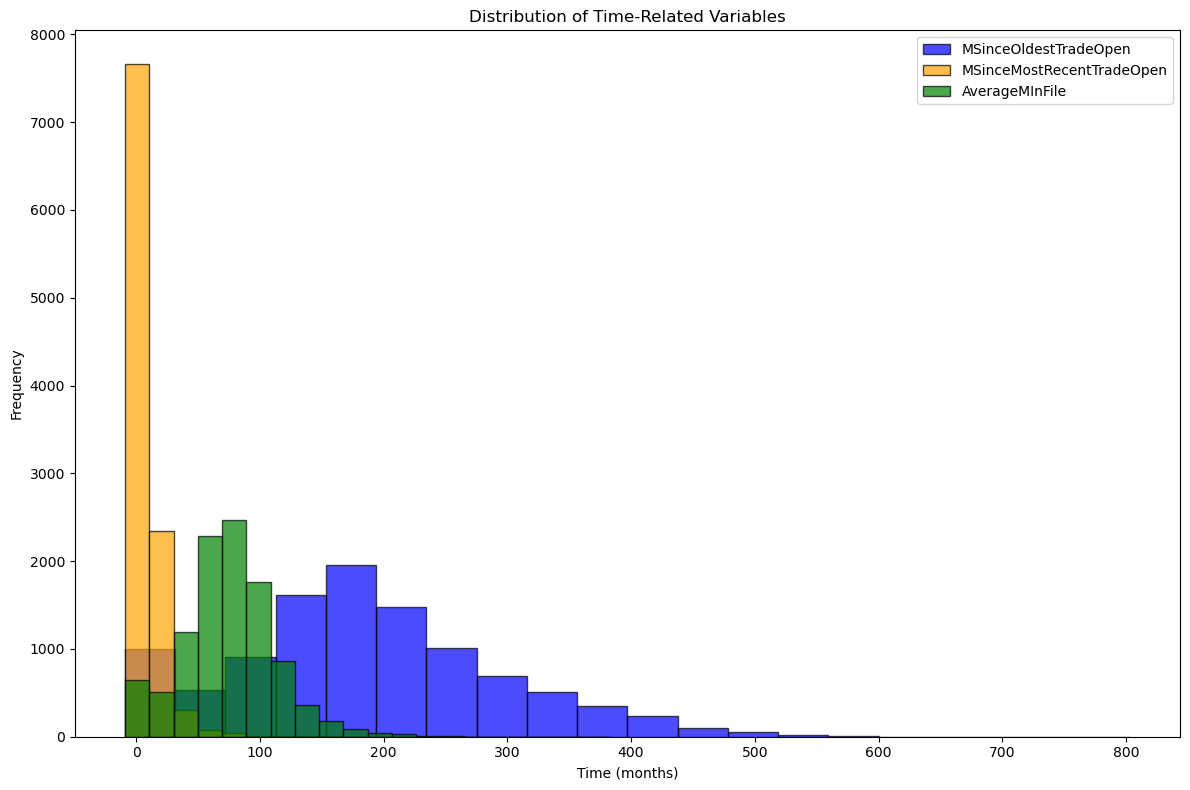

In [13]:
#Plotting Months based features
time_variables = ['MSinceOldestTradeOpen', 'MSinceMostRecentTradeOpen', 'AverageMInFile']
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(12, 8))

for variable, color in zip(time_variables, colors):
    plt.hist(df[variable], bins=20, color=color, edgecolor='black', alpha=0.7, label=variable)

plt.xlabel('Time (months)')
plt.ylabel('Frequency')
plt.title('Distribution of Time-Related Variables')
plt.legend()
plt.tight_layout()
plt.show()

#### MSinceOldestTradeOpen

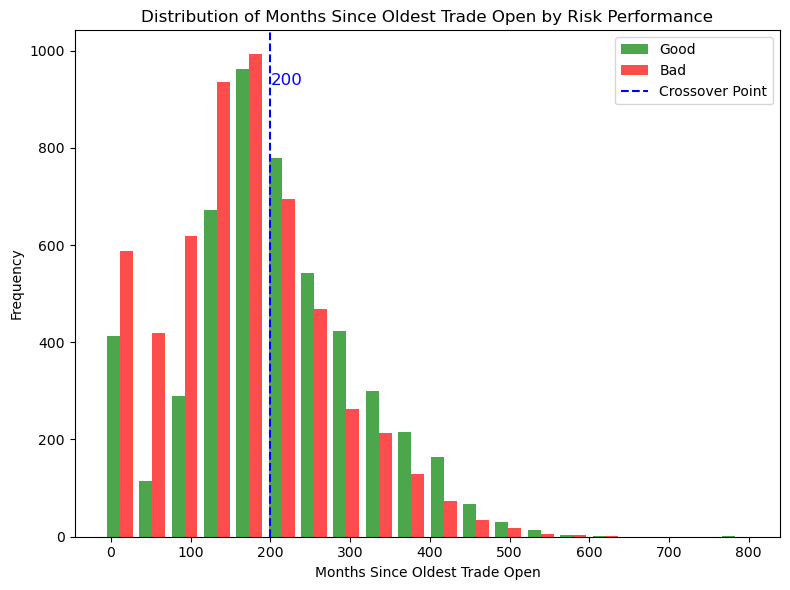

In [14]:
#Plotting good vs bad for feature
plt.figure(figsize=(8, 6))
plt.hist([df[df['RiskPerformance'] == 'Good']['MSinceOldestTradeOpen'],
          df[df['RiskPerformance'] == 'Bad']['MSinceOldestTradeOpen']],
         bins=20, alpha=0.7, color=['green', 'red'], label=['Good', 'Bad'])
plt.axvline(x=200, color='blue', linestyle='--', label='Crossover Point')
plt.xlabel('Months Since Oldest Trade Open')
plt.ylabel('Frequency')
plt.title('Distribution of Months Since Oldest Trade Open by Risk Performance')
plt.legend()
plt.text(200, plt.gca().get_ylim()[1] * 0.9, '200', color='blue', fontsize=12, va='center')
plt.tight_layout()
plt.show()

The blue line represents where it appears to the eye that there is more Good than Bad Risk Performance based on the value of this features.

#### MSinceMostRecentTradeOpen

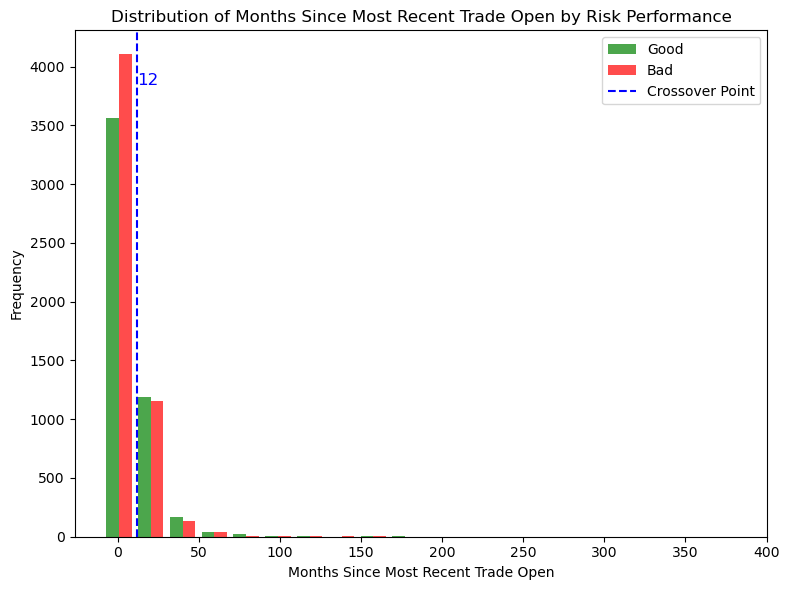

In [15]:
# Plotting histogram
plt.figure(figsize=(8, 6))
plt.hist([df[df['RiskPerformance'] == 'Good']['MSinceMostRecentTradeOpen'],
          df[df['RiskPerformance'] == 'Bad']['MSinceMostRecentTradeOpen']],
         bins=20, alpha=0.7, color=['green', 'red'], label=['Good', 'Bad'])
plt.axvline(x=12, color='blue', linestyle='--', label='Crossover Point')
plt.xlabel('Months Since Most Recent Trade Open')
plt.ylabel('Frequency')
plt.title('Distribution of Months Since Most Recent Trade Open by Risk Performance')
plt.legend()
plt.text(12, plt.gca().get_ylim()[1] * 0.9, '12', color='blue', fontsize=12, va='center')
plt.tight_layout() 
plt.show()

#### AverageMInFile

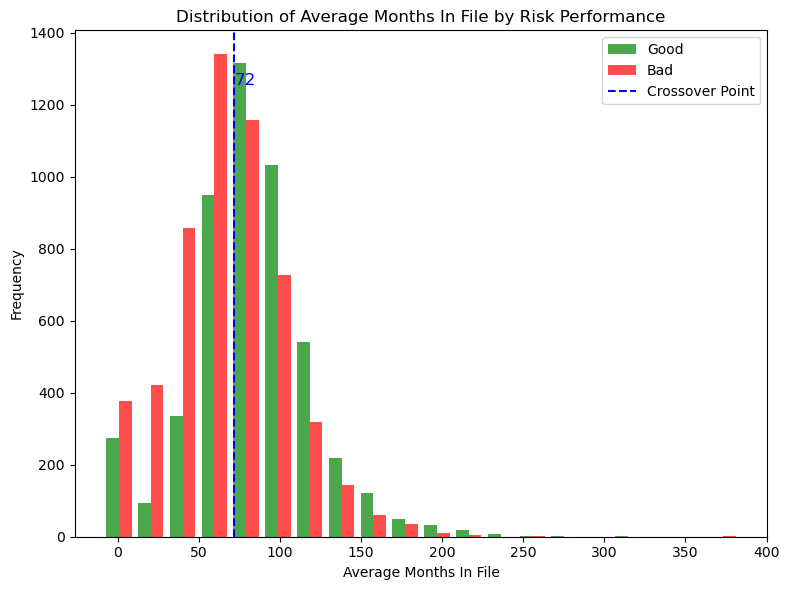

In [16]:
#Plotting histogram
plt.figure(figsize=(8, 6))
plt.hist([df[df['RiskPerformance'] == 'Good']['AverageMInFile'],
          df[df['RiskPerformance'] == 'Bad']['AverageMInFile']],
         bins=20, alpha=0.7, color=['green', 'red'], label=['Good', 'Bad'])
plt.axvline(x=72, color='blue', linestyle='--', label='Crossover Point')
plt.xlabel('Average Months In File')
plt.ylabel('Frequency')
plt.title('Distribution of Average Months In File by Risk Performance')
plt.legend()
plt.text(72, plt.gca().get_ylim()[1] * 0.9, '72', color='blue', fontsize=12, va='center')
plt.tight_layout()
plt.show()

Appears the long someone is in the file, the better they are.

#### NumSatisfactoryTrades

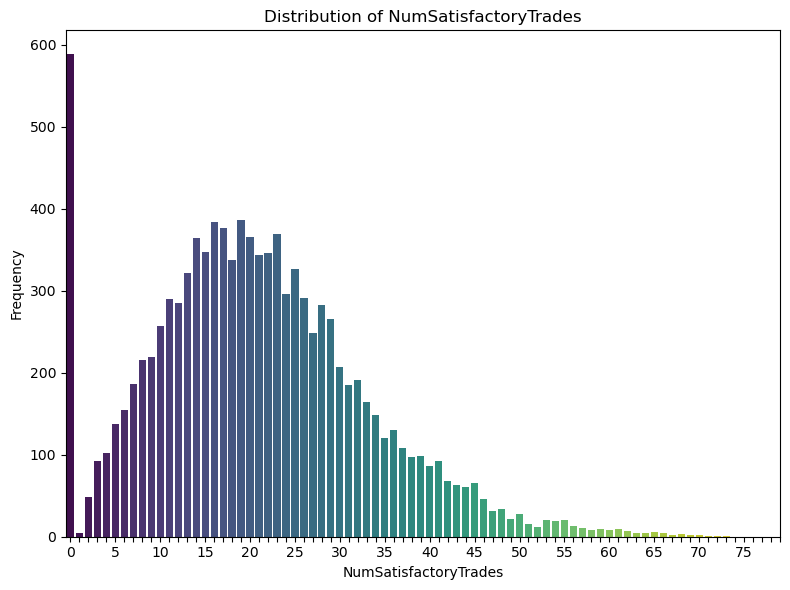

In [17]:
#Using seaborn to plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='NumSatisfactoryTrades', palette='viridis')
step = 5
max_ticks = max(df['NumSatisfactoryTrades']) + 1
tick_labels = [i if i % step == 0 and i < max_ticks else '' for i in range(max_ticks)]
ax.set_xticks(range(max_ticks))
ax.set_xticklabels(tick_labels)
plt.xlabel('NumSatisfactoryTrades')
plt.ylabel('Frequency')
plt.title('Distribution of NumSatisfactoryTrades')
plt.tight_layout()
plt.show()

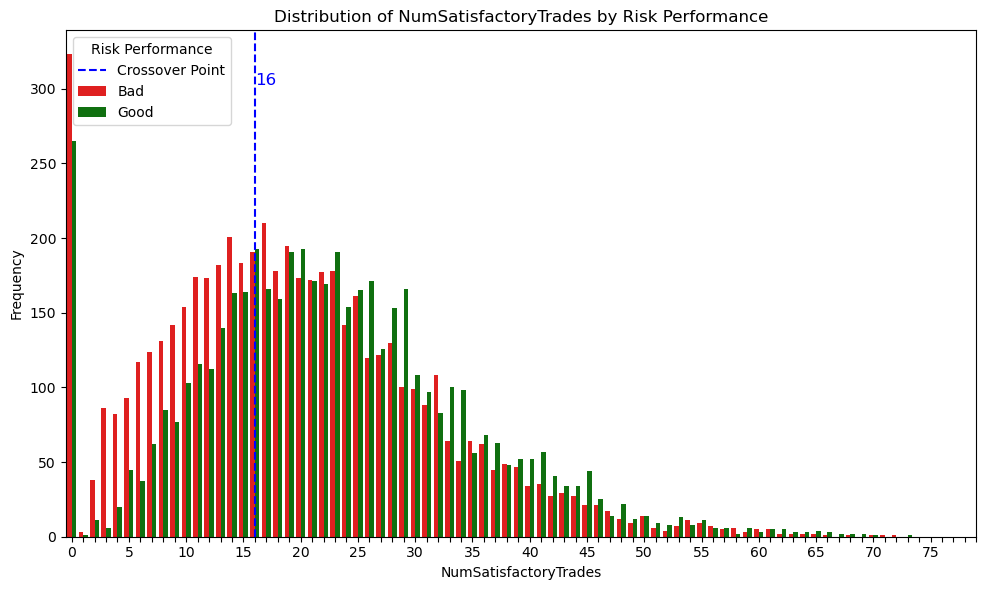

In [18]:
#Good vs bad plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='NumSatisfactoryTrades', hue='RiskPerformance', palette=['red', 'green'], hue_order=['Bad', 'Good'])
plt.axvline(x=16, color='blue', linestyle='--', label='Crossover Point')
ax.set_xlabel('NumSatisfactoryTrades')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of NumSatisfactoryTrades by Risk Performance')
plt.tight_layout()
plt.legend(title='Risk Performance')
step = 5
max_ticks = max(df['NumSatisfactoryTrades']) + 1
tick_labels = [i if i % step == 0 and i < max_ticks else '' for i in range(max_ticks)]
ax.set_xticks(range(max_ticks))  # Set explicit tick locations
ax.set_xticklabels(tick_labels)
plt.text(16, plt.gca().get_ylim()[1] * 0.9, '16', color='blue', fontsize=12, va='center')
plt.show()

The first time that we see bad more frequetly than good is at estimated 16 trades. Once trades get more than that, there is a higher liklihood of default. What is interesting is that most of the profit will be made on cusomters that use their credit more often so we cannot just shut it down at this value. 

#### NumTrades60Ever2DerogPubRec

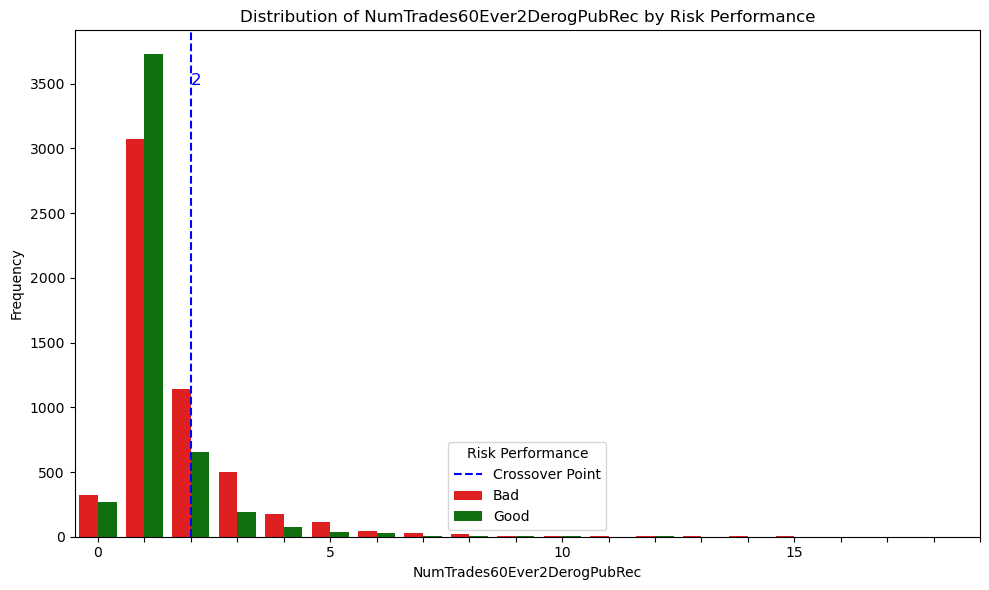

In [19]:
#Using seaborn to plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='NumTrades60Ever2DerogPubRec', hue='RiskPerformance', palette=['red', 'green'])
plt.axvline(x=2, color='blue', linestyle='--', label='Crossover Point')
ax.set_xlabel('NumTrades60Ever2DerogPubRec')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of NumTrades60Ever2DerogPubRec by Risk Performance')
plt.tight_layout()
plt.legend(title='Risk Performance')

step = 5
max_ticks = max(df['NumTrades60Ever2DerogPubRec']) + 1
tick_labels = [i if i % step == 0 and i < max_ticks else '' for i in range(max_ticks)]
ax.set_xticks(range(max_ticks))  
ax.set_xticklabels(tick_labels)

plt.text(2, plt.gca().get_ylim()[1] * 0.9, '2', color='blue', fontsize=12, va='center')

plt.show()

We know our dataset already has more Bad records than Good Risk Performance values, so we will look beyond 0 as an indicators. The number of trades that have ever been 60 days or more delinquent or that led to a derogatory public record is a very bad signal. However its not always the case. We can see here that having 2 Number of Trades is a trend that we need to look out for each bin following, Bad performance is a higher probability than Good performance.

#### NumTrades90Ever2DerogPubRec

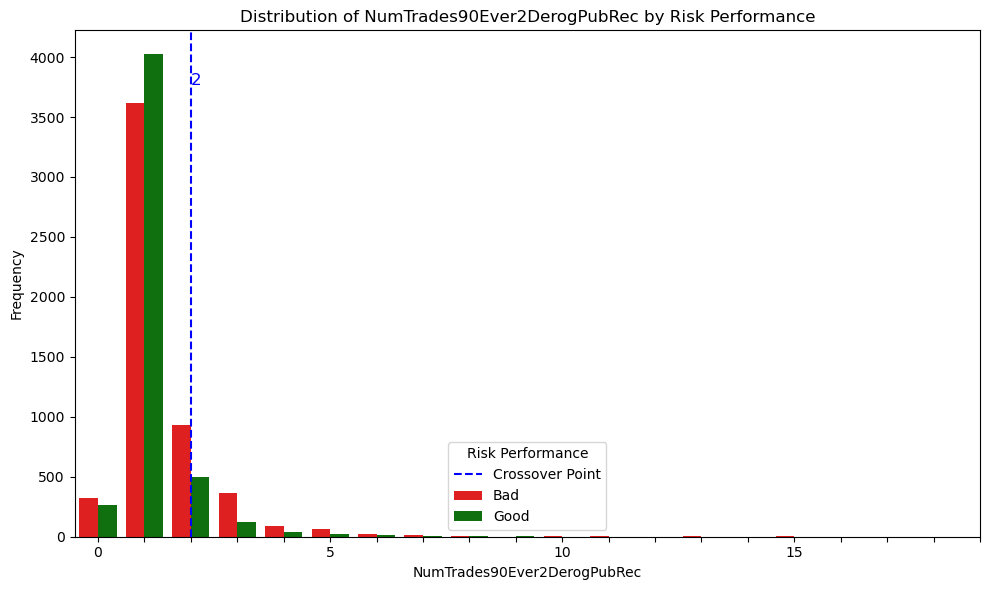

In [20]:
#Using seaborn to plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='NumTrades90Ever2DerogPubRec', hue='RiskPerformance', palette=['red', 'green'])
plt.axvline(x=2, color='blue', linestyle='--', label='Crossover Point')
ax.set_xlabel('NumTrades90Ever2DerogPubRec')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of NumTrades90Ever2DerogPubRec by Risk Performance')
plt.tight_layout()
plt.legend(title='Risk Performance')

step = 5
max_ticks = max(df['NumTrades90Ever2DerogPubRec']) + 1
tick_labels = [i if i % step == 0 and i < max_ticks else '' for i in range(max_ticks)]
ax.set_xticks(range(max_ticks))  
ax.set_xticklabels(tick_labels)

plt.text(2, plt.gca().get_ylim()[1] * 0.9, '2', color='blue', fontsize=12, va='center')

plt.show()

Interesting to note that 2 is still the crossover point. So essentially from our standpoint, whether someone goes 60 or 90 days dilinquent doesn't seem to be the biggest difference, however the frequency of each is consistent. If someone goes delinquent then their incentive to pay back immidiately has been reduced since they already have a bad mark on their record. The only reason left is to pay off their card and stop paying interest.

#### PercentTradesNeverDelq

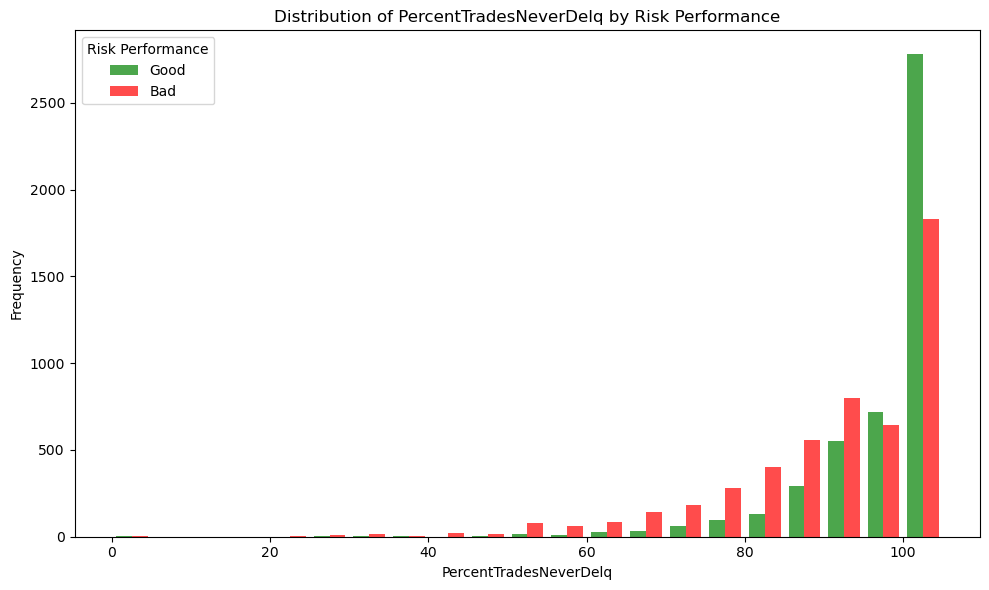

In [21]:
#Matplotlib for good vs bad 
plt.figure(figsize=(10, 6))

good_data = df[df['RiskPerformance'] == 'Good']['PercentTradesNeverDelq']
bad_data = df[df['RiskPerformance'] == 'Bad']['PercentTradesNeverDelq']

bin_edges = range(0, int(max(df['PercentTradesNeverDelq'])) + 6, 5)

plt.hist([good_data, bad_data], bins=bin_edges, alpha=0.7, color=['green', 'red'], label=['Good', 'Bad'])

plt.xlabel('PercentTradesNeverDelq')
plt.ylabel('Frequency')
plt.title('Distribution of PercentTradesNeverDelq by Risk Performance')
plt.legend(title='Risk Performance')
plt.tight_layout()

plt.show()

So it appears that people with really good track record, with higher than 67% trades that never go delinquent, that it is an indicator of good habits.

#### MaxDelq2PublicRecLast12M

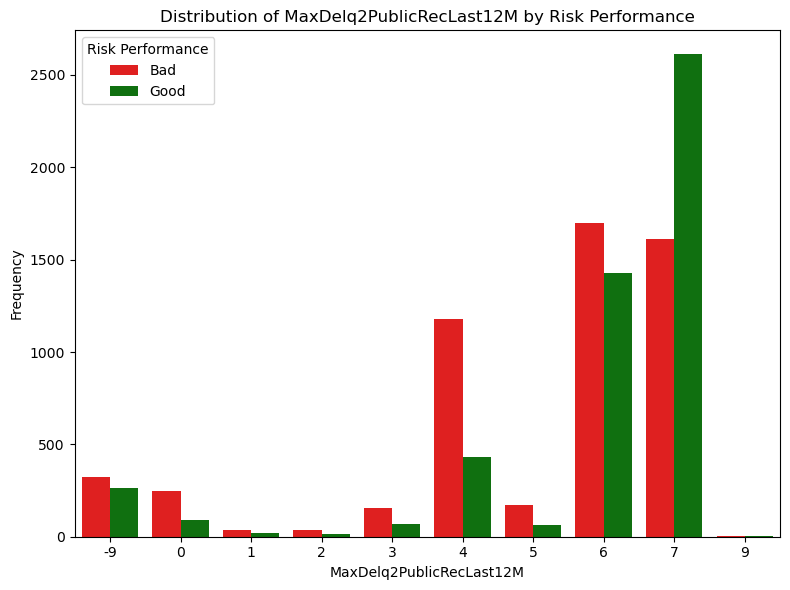

In [22]:
#Good vs bad plot for feature
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='MaxDelq2PublicRecLast12M', hue='RiskPerformance', palette=['red','green'])
ax.set_xlabel('MaxDelq2PublicRecLast12M')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of MaxDelq2PublicRecLast12M by Risk Performance')
plt.tight_layout()
plt.legend(title='Risk Performance')
plt.show()

#### MaxDelqEver

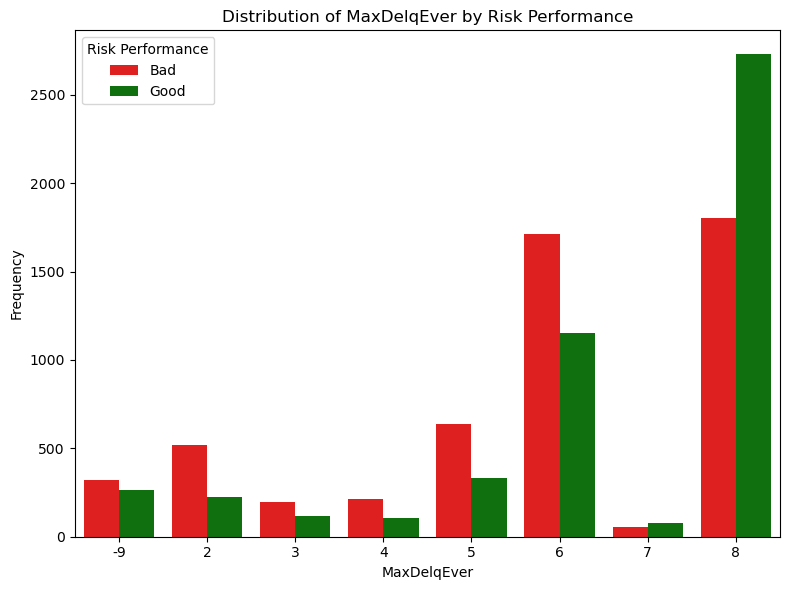

In [23]:
#Good vs bad plot per feature
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='MaxDelqEver', hue='RiskPerformance', palette=['red','green'])
ax.set_xlabel('MaxDelqEver')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of MaxDelqEver by Risk Performance')
plt.tight_layout()
plt.legend(title='Risk Performance')
plt.show()

#### PercentInstallTrades

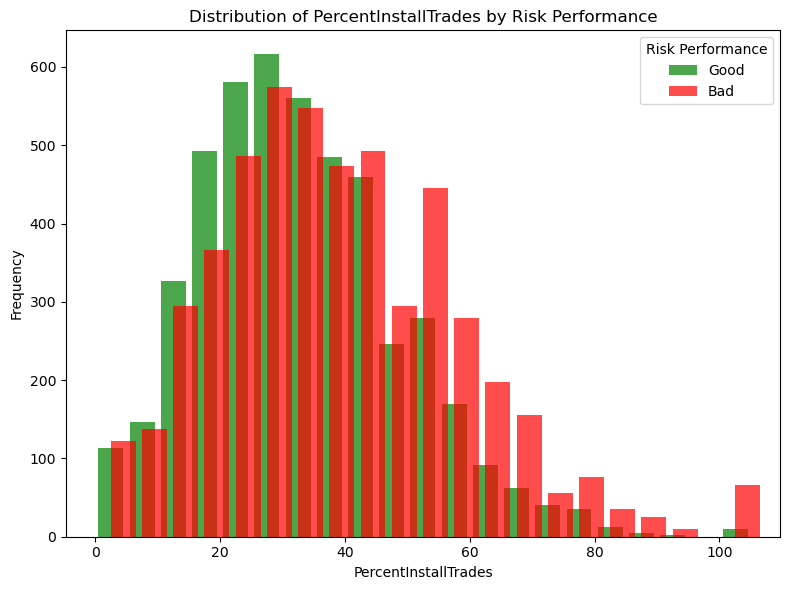

In [24]:
#Good vs bad plot per feature
plt.figure(figsize=(8, 6))

good_data = df[df['RiskPerformance'] == 'Good']['PercentInstallTrades']
bad_data = df[df['RiskPerformance'] == 'Bad']['PercentInstallTrades']

bin_edges = range(0, int(max(df['PercentInstallTrades'])) + 6, 5)

plt.hist([good_data, bad_data], bins=bin_edges, alpha=0.7, color=['green', 'red'], label=['Good', 'Bad'])

plt.xlabel('PercentInstallTrades')
plt.ylabel('Frequency')
plt.title('Distribution of PercentInstallTrades by Risk Performance')
plt.legend(title='Risk Performance')
plt.tight_layout()

bar_width = 4 
for patch in plt.gca().patches:
    patch.set_width(bar_width)

plt.show()

Bettern 35 and 40 we see Risk Performance go worse the higher this value is.

#### PercentTradesWBalance

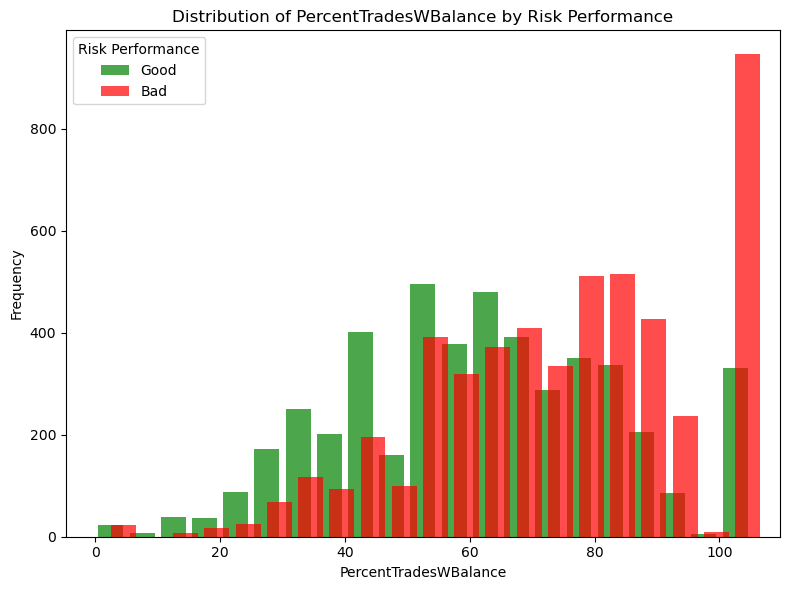

In [25]:
#Good vs bad plot for feature
plt.figure(figsize=(8, 6))

good_data = df[df['RiskPerformance'] == 'Good']['PercentTradesWBalance']
bad_data = df[df['RiskPerformance'] == 'Bad']['PercentTradesWBalance']

bin_edges = range(0, int(max(df['PercentTradesWBalance'])) + 6, 5)

plt.hist([good_data, bad_data], bins=bin_edges, alpha=0.7, color=['green', 'red'], label=['Good', 'Bad'])

plt.xlabel('PercentTradesWBalance')
plt.ylabel('Frequency')
plt.title('Distribution of PercentTradesWBalance by Risk Performance')
plt.legend(title='Risk Performance')
plt.tight_layout()

bar_width = 4 
for patch in plt.gca().patches:
    patch.set_width(bar_width)

plt.show()

#### MSinceMostRecentDelq, MSinceMostRecentInqexcl7days, NumInqLast6M, NumInqLast6Mexcl7days, NetFractionRevolvingBurden, NetFractionInstallBurden, NumRevolvingTradesWBalance, NumInstallTradesWBalance, & NumBank2NatlTradesWHighUtilization

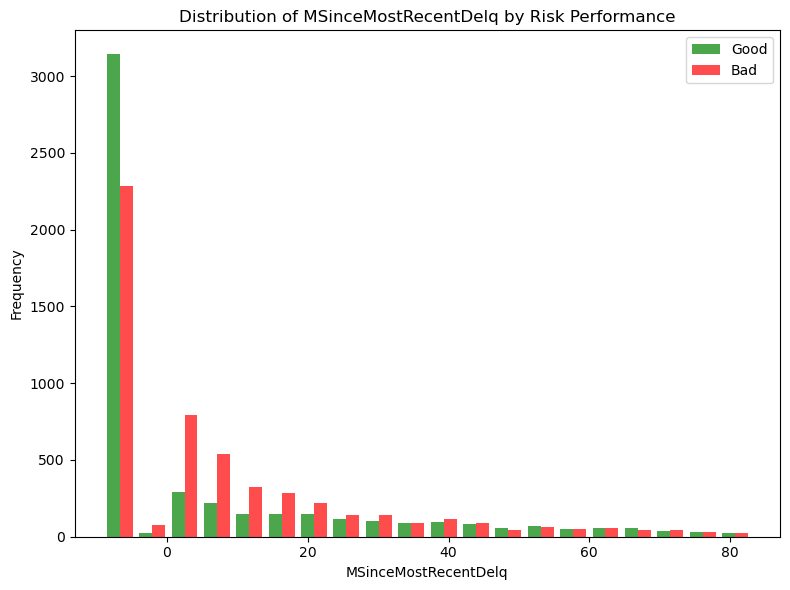

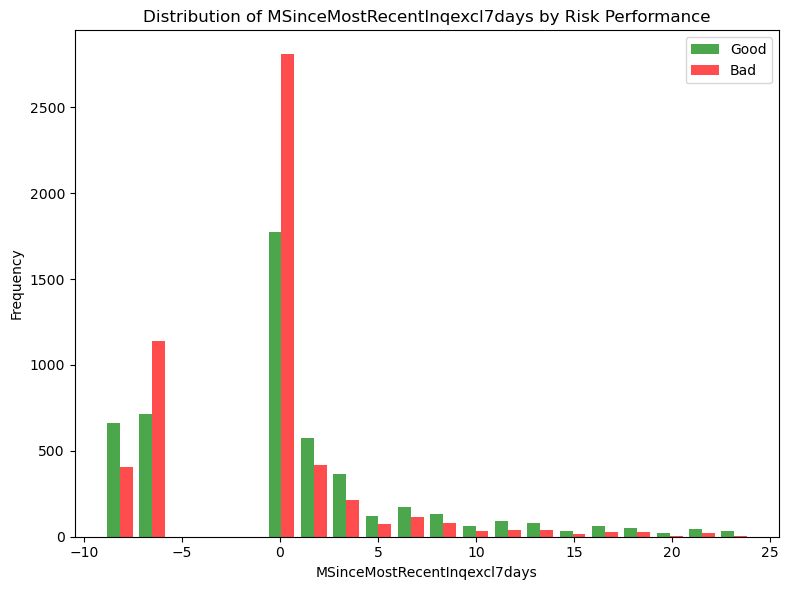

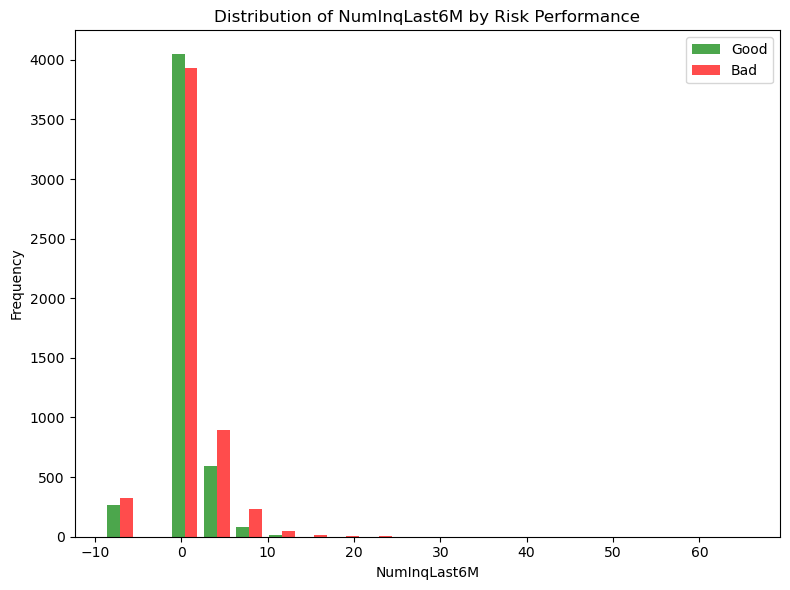

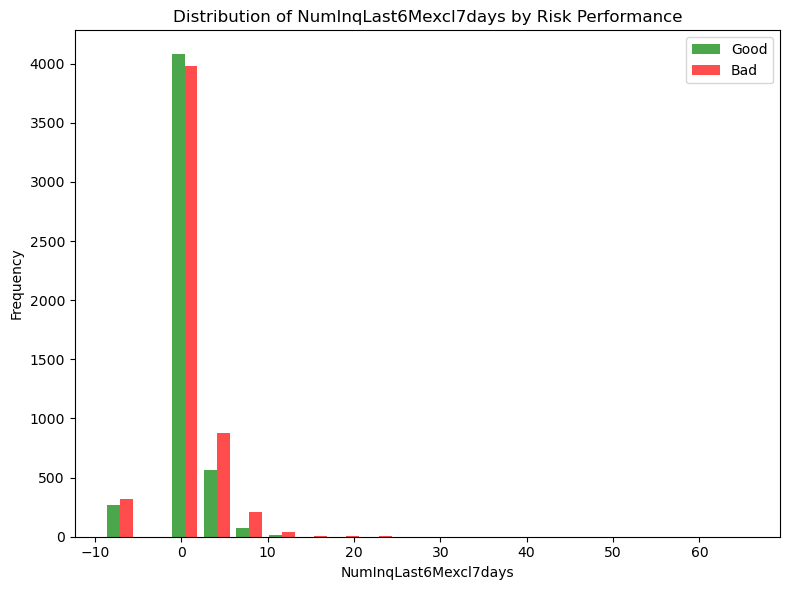

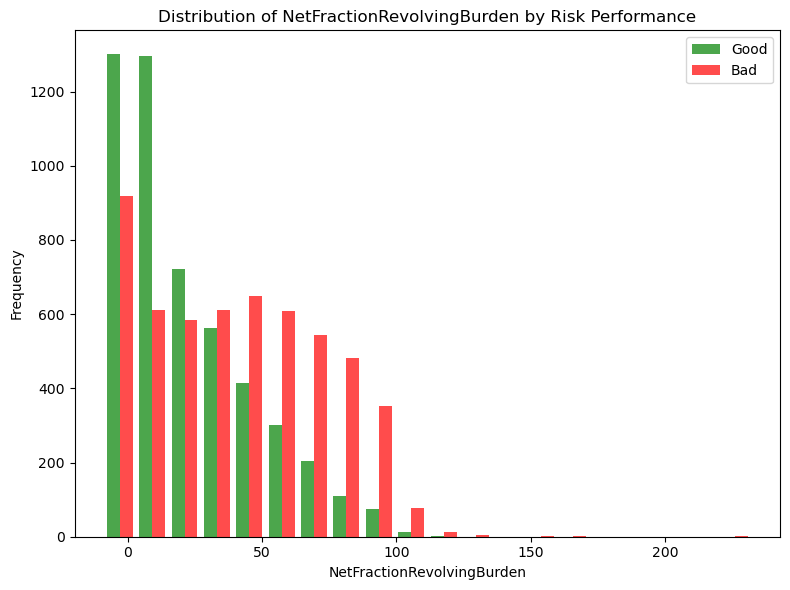

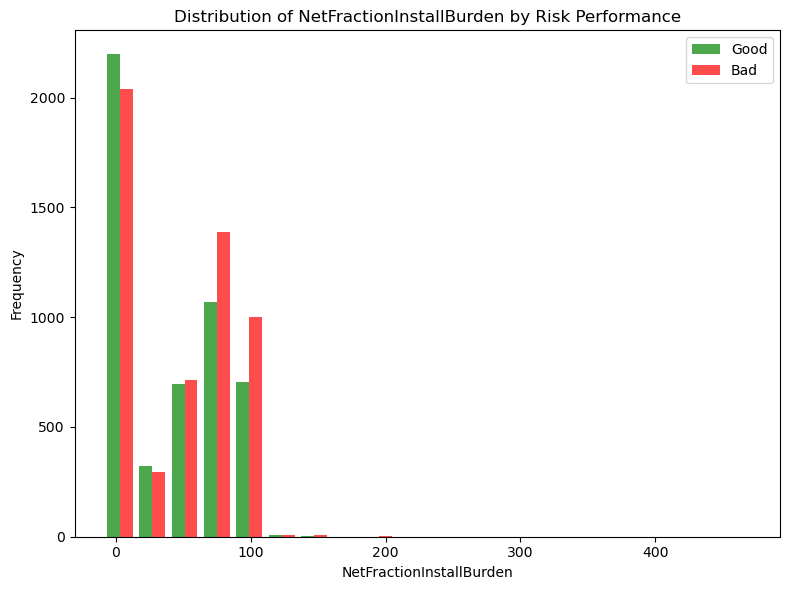

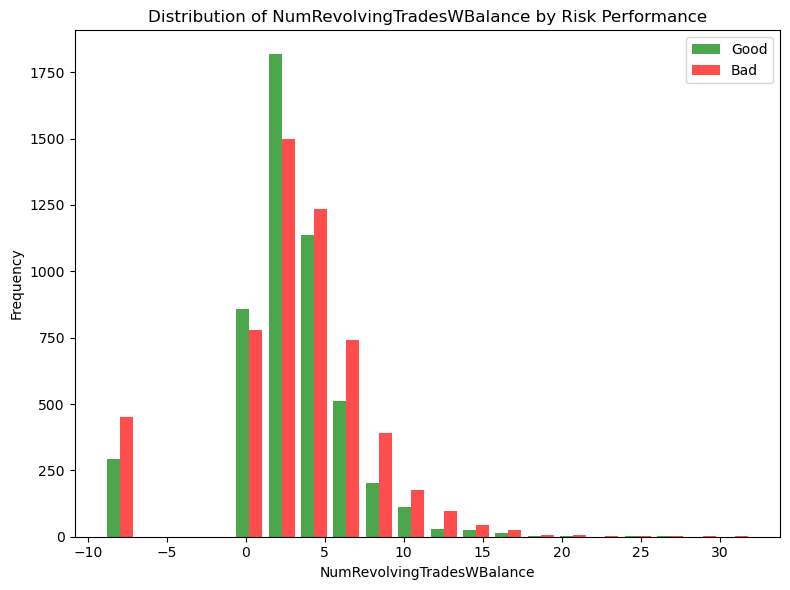

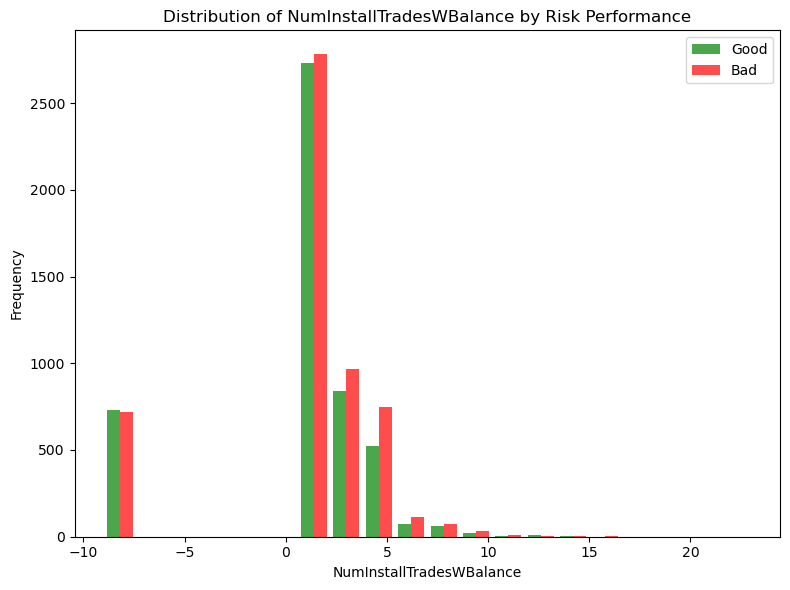

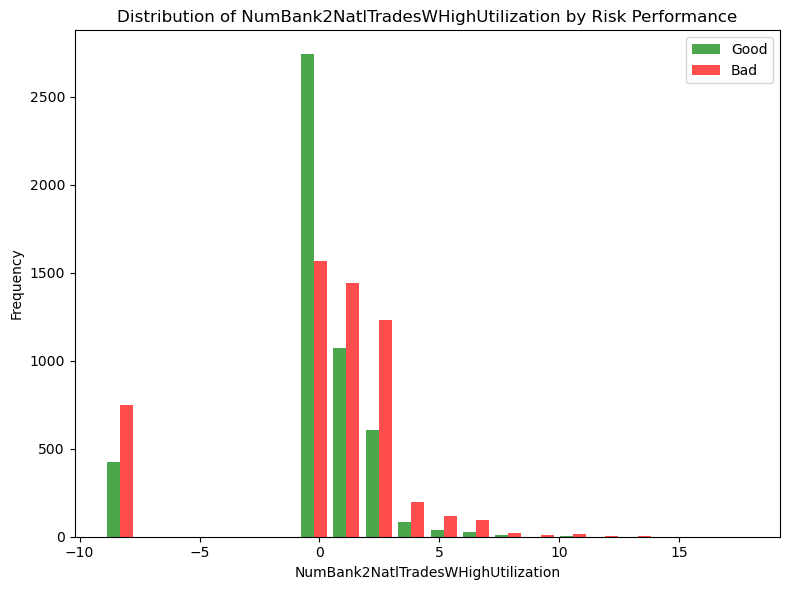

In [26]:
#Plots for remaining features
numerical_vars = ['MSinceMostRecentDelq', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 
                  'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden', 'NetFractionInstallBurden', 
                  'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance', 'NumBank2NatlTradesWHighUtilization']

for var in numerical_vars:
    plt.figure(figsize=(8, 6))
    
    plt.hist([df[df['RiskPerformance'] == 'Good'][var], df[df['RiskPerformance'] == 'Bad'][var]],
             bins=20, alpha=0.7, color=['green', 'red'], label=['Good', 'Bad'])
    
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {var} by Risk Performance')
    plt.legend()
    plt.tight_layout()
    plt.show()

#### NumTotalTrades, & NumTradesOpeninLast12M

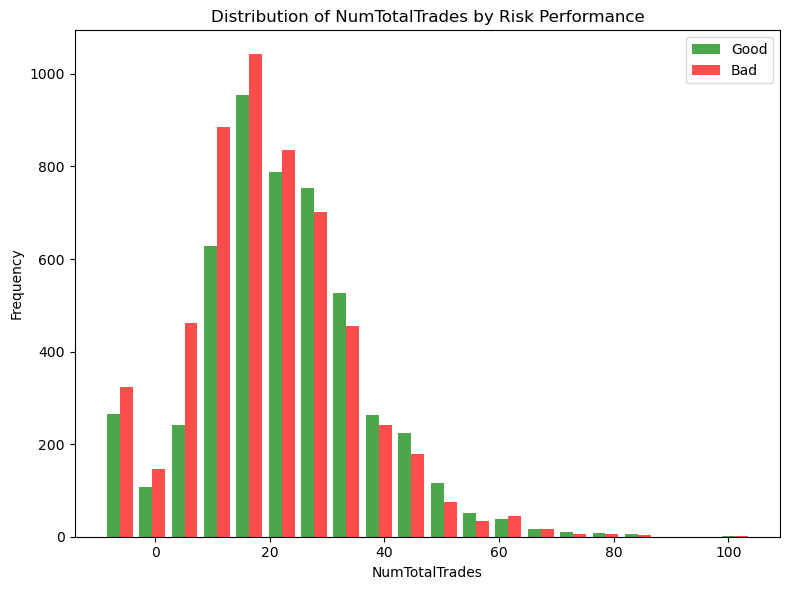

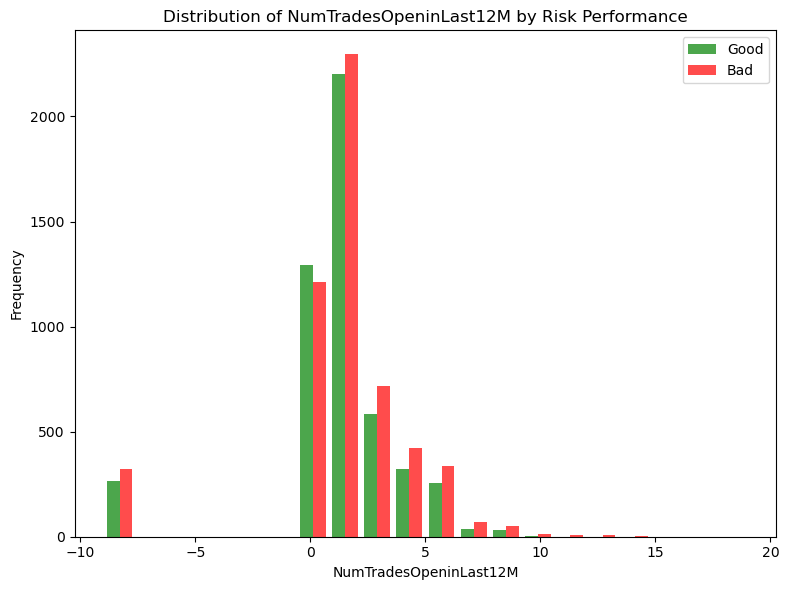

In [27]:
#Plots
numerical_vars = ['NumTotalTrades', 'NumTradesOpeninLast12M']

for var in numerical_vars:
    plt.figure(figsize=(8, 6))
    

    plt.hist([df[df['RiskPerformance'] == 'Good'][var], df[df['RiskPerformance'] == 'Bad'][var]],
             bins=20, alpha=0.7, color=['green', 'red'], label=['Good', 'Bad'])
    
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {var} by Risk Performance')
    plt.legend()
    plt.tight_layout()
    plt.show()

Now that we have a basic understanding of each of the values and how they relate to Risk Performance by value, let's look at the business case and see what we can do.

# 4. Understanding the Business Case

The business use case of this is to create a model that can predict if a borrower will default based on the data provided here. The target output will be RiskPerformance feature.

The business use case is primarily driven by two factors, to provide as many loans as possible as to make profit from interest, and to prevent losses due to people defaulting on their loans. In addition, creating our own models and showing their effectiveness also gives our bank an additional ability to not hold as much captial per trade of credit we offer. This enables us to provide more credit to more people and thus make more interest per dollar that we don't have to store as collateral. Lastly, which is outside the scope of this, all models will need to be able to be audited and essentially interpretable. I will do my best to show how all the models are performing and to the ones that perform best, I will show graphs of their features impacts via partial dependence plots etc.

# 5. Engineering Features

In [28]:
# Updating RiskPerformance for correlation matrix. Bad is 1 and Good is 0, this way we are predicting if someone will be bad or not since this is a Risk business case.
df['RiskPerformance'] = df['RiskPerformance'].replace({'Bad': 1, 'Good': 0})

In [29]:
correlation_matrix = df.corr()

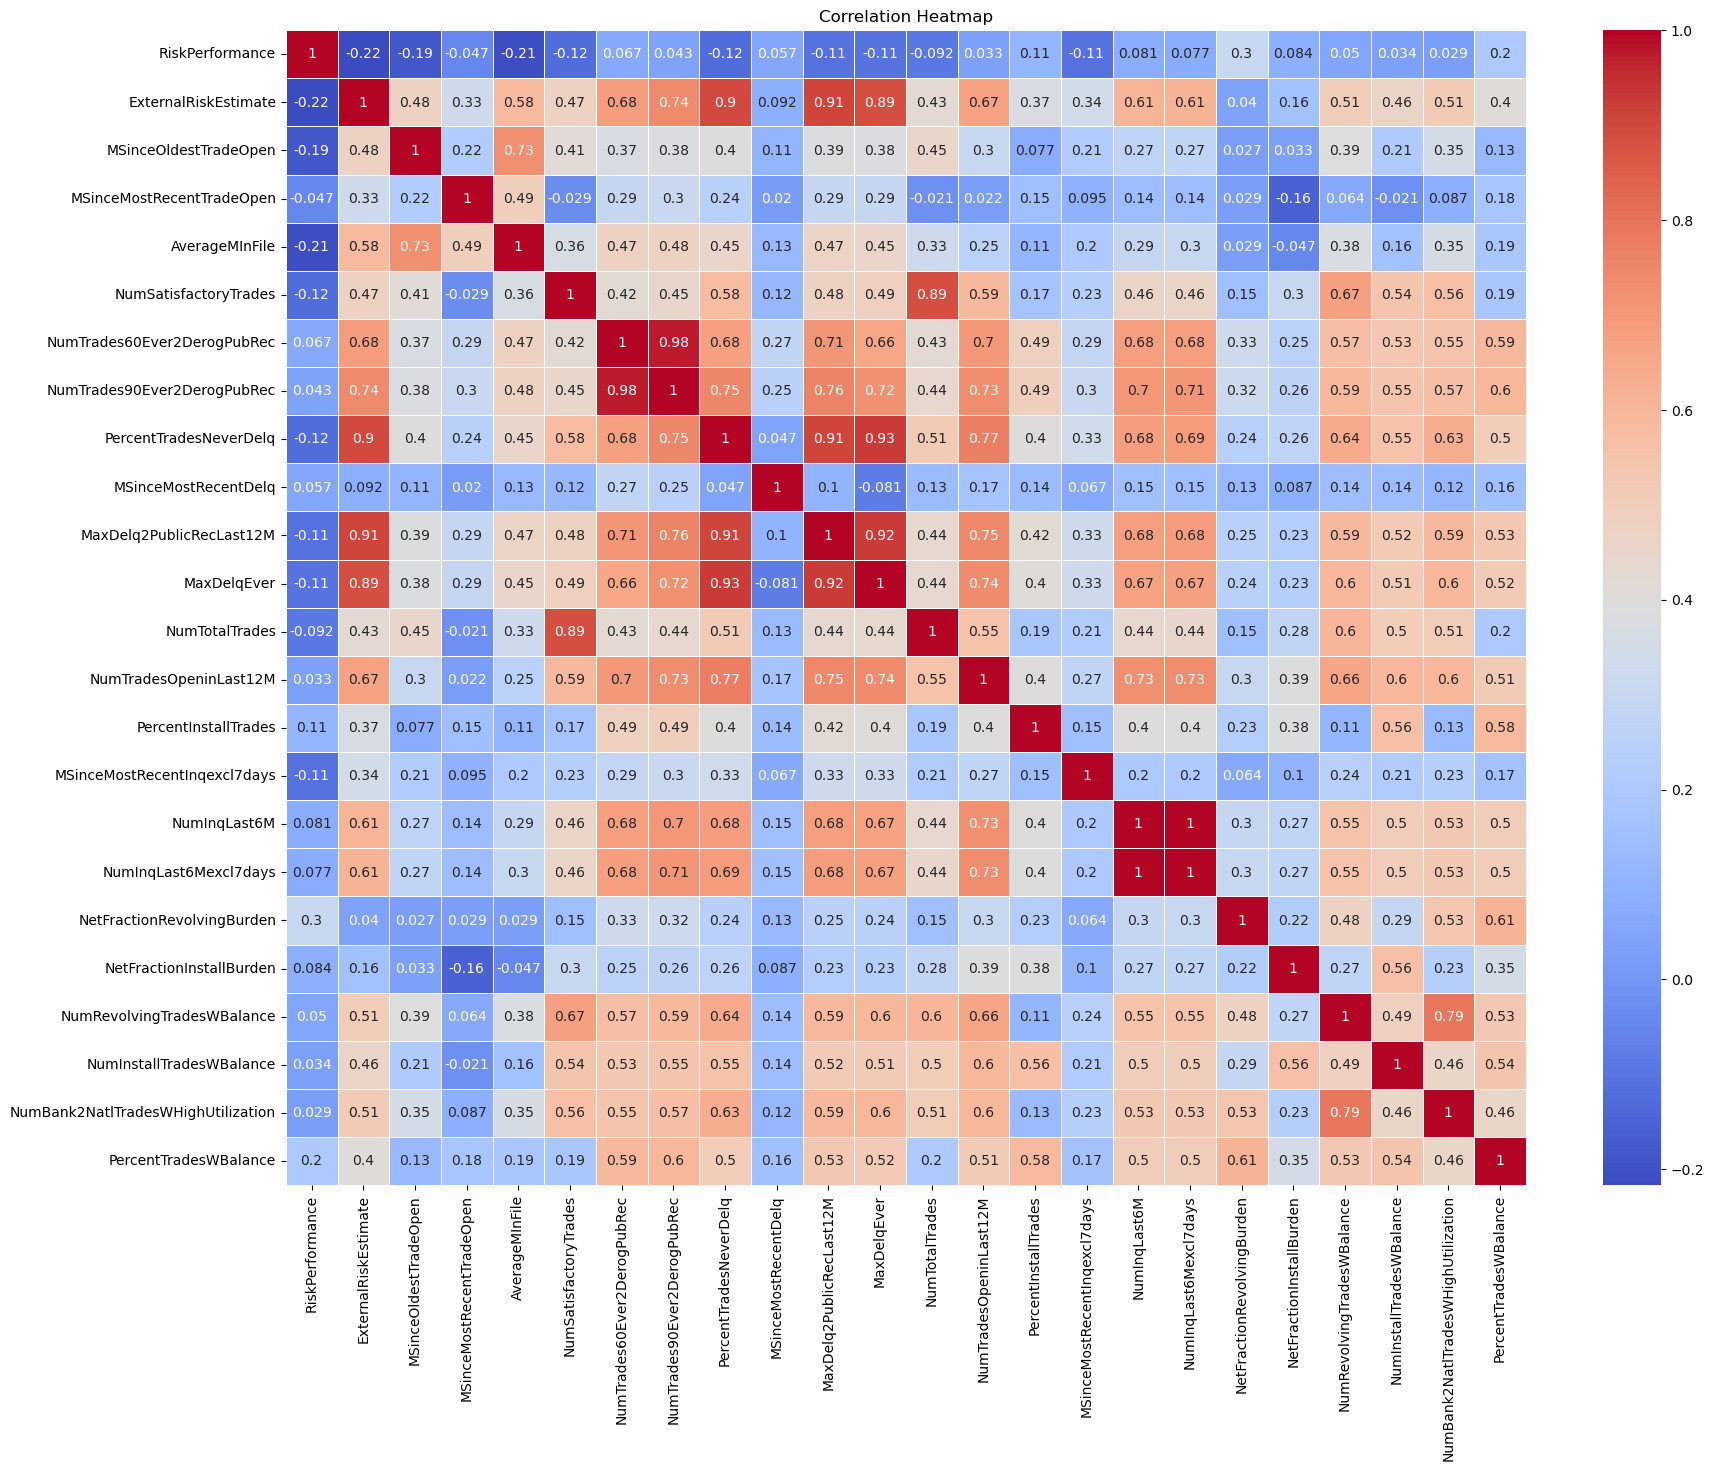

In [30]:
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [31]:
column_order = correlation_matrix.abs().sum().sort_values(ascending=False).index

In [32]:
ordered_corr_matrix = correlation_matrix.loc[column_order, column_order]

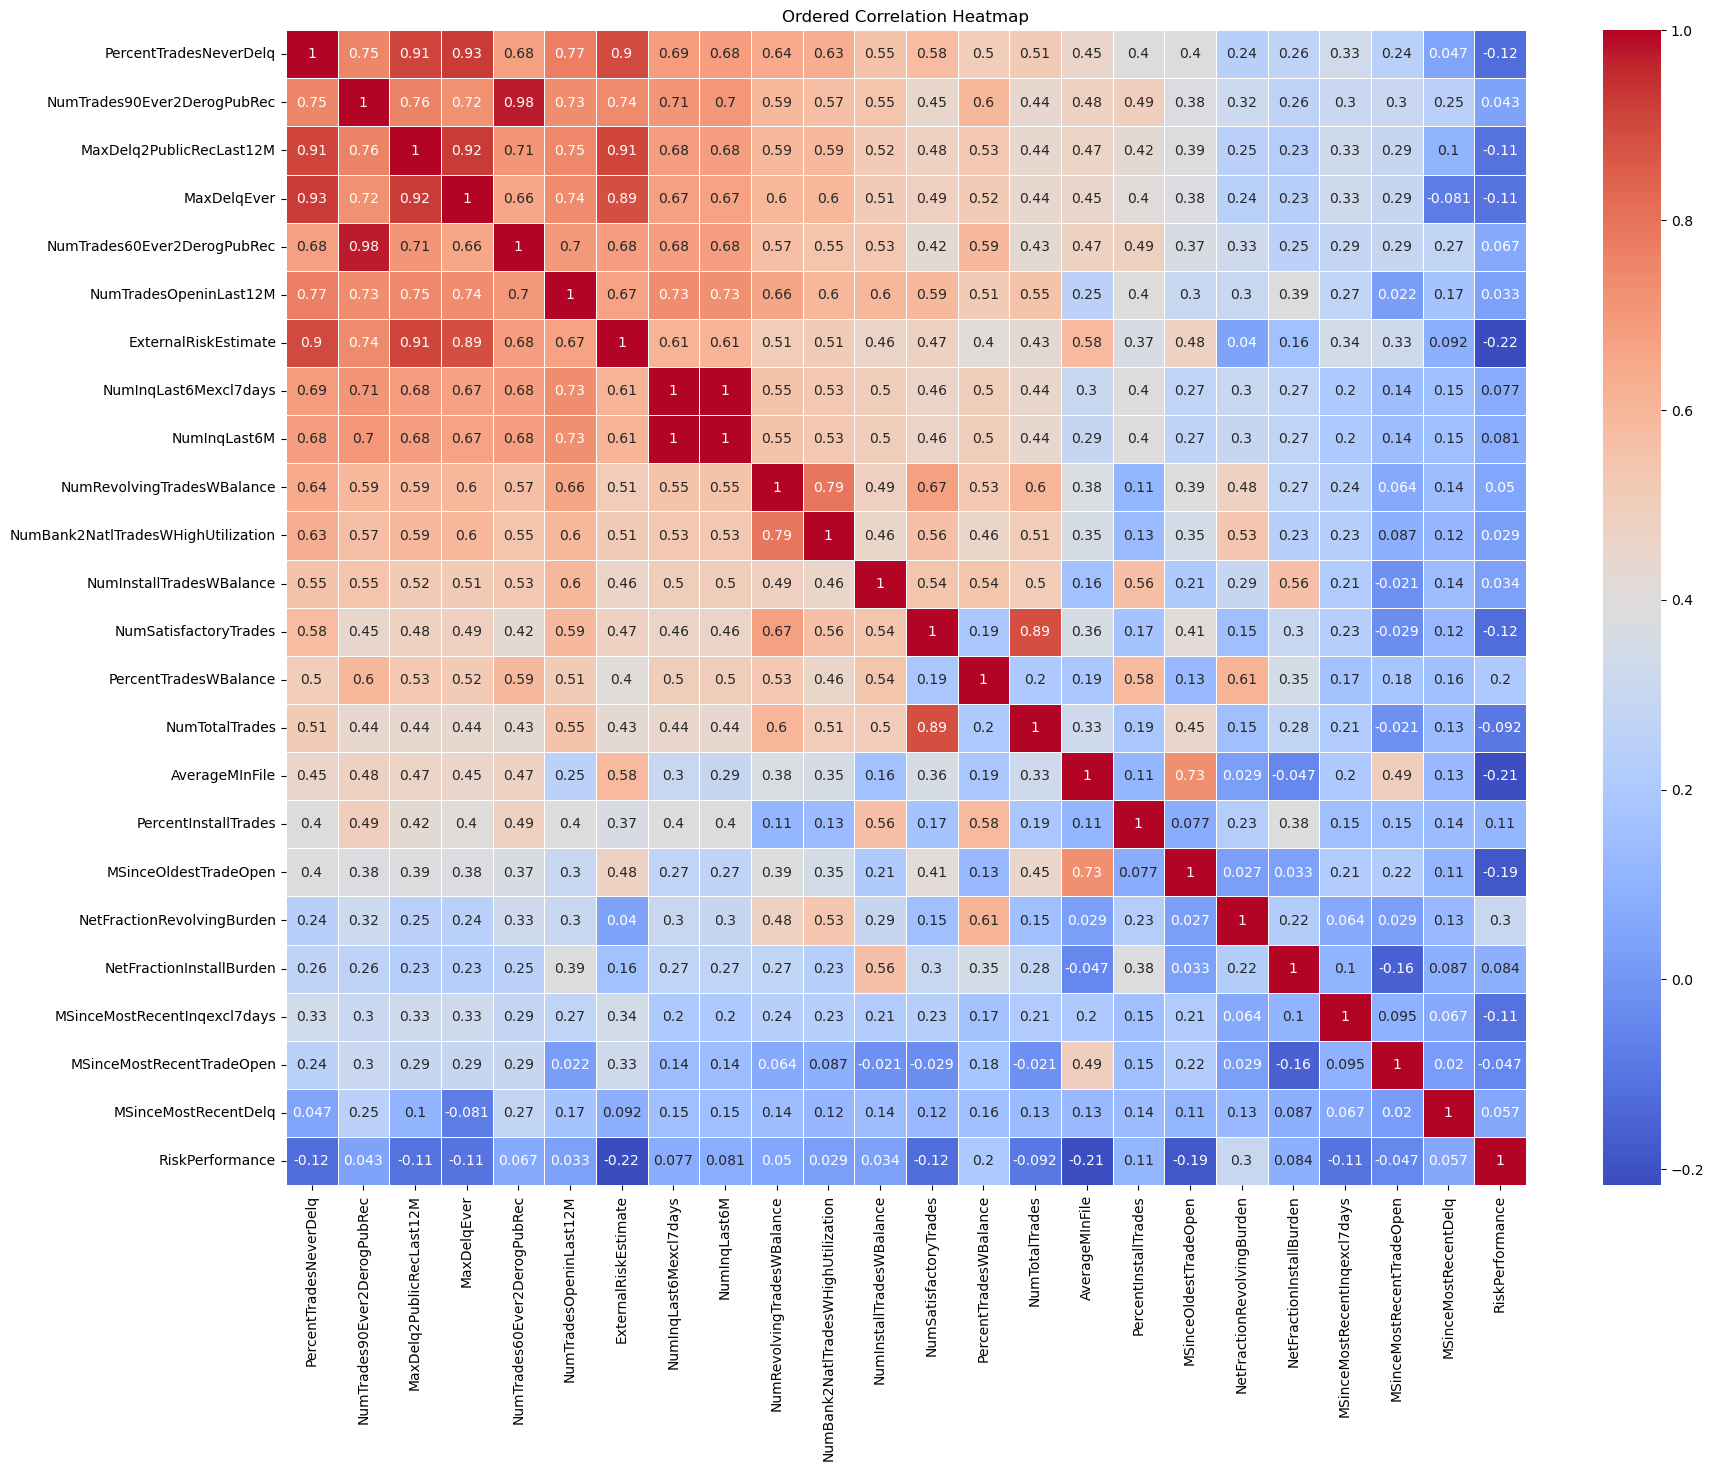

In [33]:
plt.figure(figsize=(20, 15))
sns.heatmap(ordered_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Ordered Correlation Heatmap')
plt.show()

In [34]:
#Finding the highest correlated features to Risk Performance
risk_performance_corr = correlation_matrix['RiskPerformance'].sort_values(ascending=False)

In [35]:
risk_performance_corr

RiskPerformance                       1.000000
NetFractionRevolvingBurden            0.298174
PercentTradesWBalance                 0.198554
PercentInstallTrades                  0.111542
NetFractionInstallBurden              0.083645
NumInqLast6M                          0.080964
NumInqLast6Mexcl7days                 0.076660
NumTrades60Ever2DerogPubRec           0.067211
MSinceMostRecentDelq                  0.057067
NumRevolvingTradesWBalance            0.050099
NumTrades90Ever2DerogPubRec           0.043402
NumInstallTradesWBalance              0.034337
NumTradesOpeninLast12M                0.032649
NumBank2NatlTradesWHighUtilization    0.029091
MSinceMostRecentTradeOpen            -0.046937
NumTotalTrades                       -0.091504
MaxDelqEver                          -0.107204
MaxDelq2PublicRecLast12M             -0.109946
MSinceMostRecentInqexcl7days         -0.110253
PercentTradesNeverDelq               -0.122010
NumSatisfactoryTrades                -0.123080
MSinceOldestT

What is interestsing here is we really don't have a very clear linear relationship with one or two features. It is interesting to understand that a higher External Risk Estimate value means a stronger credit position and lower risk. It's good to keep that in mind. I am going to re-order this list based on absolute value.

In [36]:
#Absolute value to rank and stack and select top .1 or higher correlative features.
risk_performance_corr = risk_performance_corr.abs().sort_values(ascending=False)


In [37]:
risk_performance_corr

RiskPerformance                       1.000000
NetFractionRevolvingBurden            0.298174
ExternalRiskEstimate                  0.216770
AverageMInFile                        0.209168
PercentTradesWBalance                 0.198554
MSinceOldestTradeOpen                 0.185155
NumSatisfactoryTrades                 0.123080
PercentTradesNeverDelq                0.122010
PercentInstallTrades                  0.111542
MSinceMostRecentInqexcl7days          0.110253
MaxDelq2PublicRecLast12M              0.109946
MaxDelqEver                           0.107204
NumTotalTrades                        0.091504
NetFractionInstallBurden              0.083645
NumInqLast6M                          0.080964
NumInqLast6Mexcl7days                 0.076660
NumTrades60Ever2DerogPubRec           0.067211
MSinceMostRecentDelq                  0.057067
NumRevolvingTradesWBalance            0.050099
MSinceMostRecentTradeOpen             0.046937
NumTrades90Ever2DerogPubRec           0.043402
NumInstallTra

In [38]:
df_target = df['RiskPerformance']

In [39]:
df_heloc = df.drop('RiskPerformance',axis=1)

In [40]:
df_heloc.columns

Index(['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance'],
      dtype='object')

I'm going to limit the columns to any that have a correlation of .1 or higher from the risk_performance_corr. This was a good guideline for my Practical Assignment 3 so I'm going to start here to see what models may work best and find an even better coefficient ranking of the the features. Based on previous experience, I ran models on all the features, on features that were .1 and .2 or more correlation. Accuracy was best at .1. This is also an industry standard to only select the features that Importance Value is above .1. However we are not calculating importance value, but correlation but it still works here.

In [41]:
relevant_columns = risk_performance_corr[risk_performance_corr.abs() >= 0.1].index


In [42]:
relevant_columns = [col for col in relevant_columns if col != 'RiskPerformance']
df_heloc_filtered = df_heloc[relevant_columns]


# 6. Test/Train Split

In [43]:
#Splitting the data so we train the model onseparate data than we test its results against
X_train, X_test, y_train, y_test = train_test_split(df_heloc_filtered, df_target, test_size=0.2, random_state=42)

In [44]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8367, 11)
X_test shape: (2092, 11)
y_train shape: (8367,)
y_test shape: (2092,)


# 7. Baseline Model

In [45]:
#Counting the difference in the training set
counts = y_train.value_counts()
count_0 = counts.get(0, 0)
count_1 = counts.get(1, 0) 

print(f"Number of 0s: {count_0}")
print(f"Number of 1s: {count_1}")


Number of 0s: 3996
Number of 1s: 4371


Calculating how often 1 or Bad is in the Risk Performance y_train data.

In [46]:
4371 / (3996+4371)

0.5224094657583364

Appears that 52% of the time, we have a bad credit performance per the dataset.

In [47]:
majority_class = y_train.value_counts().idxmax()

In [48]:
baseline_accuracy = (y_test == majority_class).mean()

In [49]:
print("Baseline Accuracy:", baseline_accuracy)

Baseline Accuracy: 0.5200764818355641


This matches very closely to how often a bad rating is in the data. Let's see what we can do from here.

# 8. Simple Model

Common industry standard from credit risk is to use Logisitic Regression. I am interested to see how the other model types fair. Let's setup a simple model here.

In [50]:
logreg = LogisticRegression(max_iter=1000)

In [51]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [52]:
y_pred = logreg.predict(X_test)

In [53]:
accuracy = (y_pred == y_test).mean()

# 9. Score the Model

In [54]:
print("Accuracy:", accuracy)

Accuracy: 0.6658699808795411


In [55]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [56]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6658699808795411
Precision: 0.6786042240587695
Recall: 0.6792279411764706
F1 Score: 0.6789159393661001


**Interpreting these results**: Precision here tells us that when our model or bank believes someone is a good borrorwer that they are. High Precision will reduce defaults. A strong Recall score will ensure the bank is making money by not too highly rejecting loans to otherwise good borrowers.

In [57]:
confusion_matrix = confusion_matrix(y_test, y_pred)

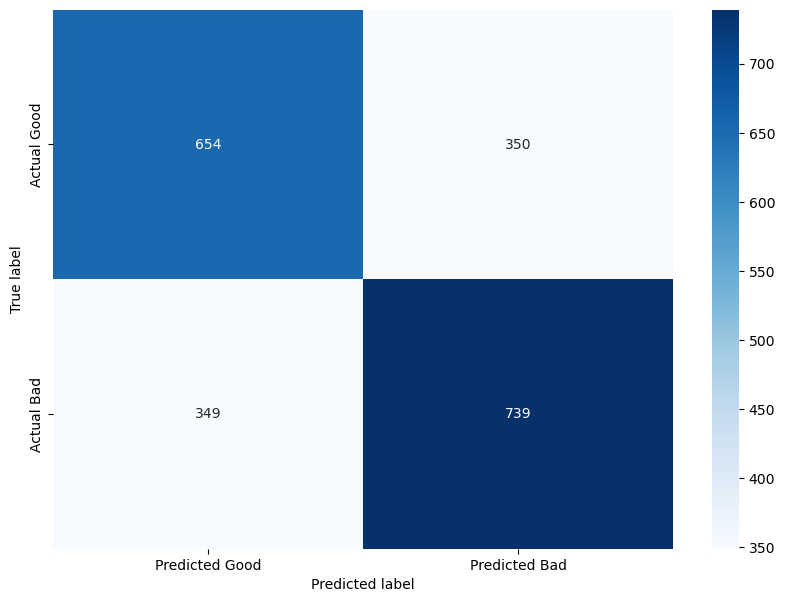

In [58]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted Good', 'Predicted Bad'], 
            yticklabels=['Actual Good', 'Actual Bad'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [59]:
cm_percentage = confusion_matrix / confusion_matrix.sum() * 100


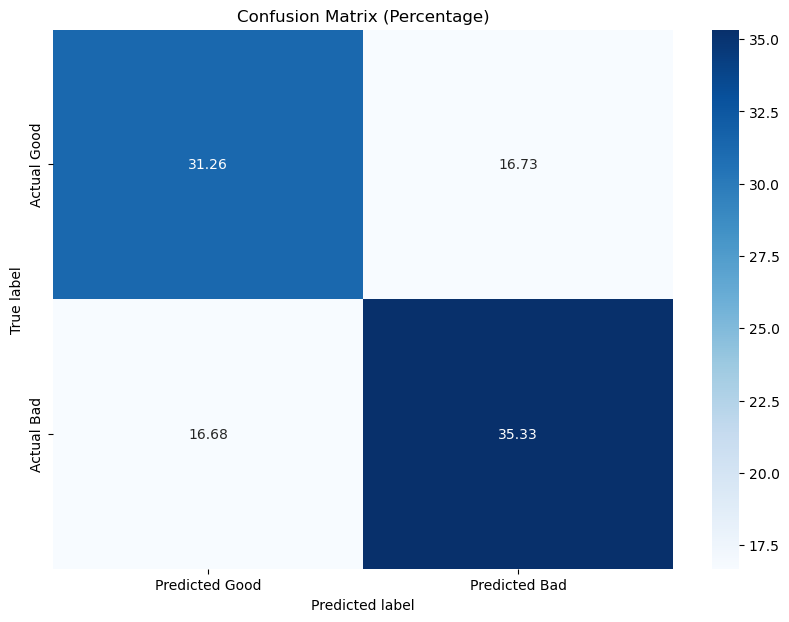

In [60]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted Good', 'Predicted Bad'], 
            yticklabels=['Actual Good', 'Actual Bad'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix (Percentage)')
plt.show()

**True Positive**: (Top left quadrant)The model predicts the applicant will be a good borrower (not default), and they actually don't default.

**False Positive**: (Top right quadrant) The model predicts the applicant will be a good borrower, but they default. This is risky for the bank as it ends up lending to a borrower who then defaults.

**True Negative**:  (Bottom right quadrant) The model predicts the applicant will default (be a bad borrower), and they do. This is the scenario where the bank avoids potential bad loans.

**False Negative**: (Bottom left quadrant) The model predicts the applicant will default, but they do not. This is a lost opportunity for the bank because it incorrectly denied a loan to a good borrower from whom it could have earned interest.

# 10. Model Comparisons

We are going to look at Logistic Regression model, K Nearest Neighbors, Decision Tree, and Support Vector Machines.

In [61]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000), 
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True)
}

In [62]:
model_names = []
model_params = []
train_times = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []
train_aucs = []
test_aucs = []

In [63]:
#Testing different models
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Accuracy
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Precision
    train_precision = precision_score(y_train, train_pred)
    test_precision = precision_score(y_test, test_pred)
    
    # Recall
    train_recall = recall_score(y_train, train_pred)
    test_recall = recall_score(y_test, test_pred)
    
    # F1 Score
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    
    # AUC
    train_pred_prob = model.predict_proba(X_train)[:, 1] 
    test_pred_prob = model.predict_proba(X_test)[:, 1]
    train_auc = roc_auc_score(y_train, train_pred_prob)
    test_auc = roc_auc_score(y_test, test_pred_prob)
    #Appending results from all the model tests into one chart
    model_params.append(model.get_params())
    model_names.append(model_name)
    train_times.append(train_time)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_precisions.append(train_precision)
    test_precisions.append(test_precision)
    train_recalls.append(train_recall)
    test_recalls.append(test_recall)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)

In [64]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Train Time': train_times,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Train Precision': train_precisions,
    'Test Precision': test_precisions,
    'Train Recall': train_recalls,
    'Test Recall': test_recalls,
    'Train F1 Score': train_f1s,
    'Test F1 Score': test_f1s,
    'Train AUC': train_aucs,
    'Test AUC': test_aucs,
    'Parameters': model_params
})

In [65]:
results_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters
0,Logistic Regression,0.197012,0.696665,0.665870,0.703621,0.678604,0.724548,0.679228,0.713931,0.678916,0.754952,0.722895,"{'C': 1.0, 'class_weight': None, 'dual': False..."
1,KNN,0.005244,0.770647,0.648662,0.768389,0.653345,0.803020,0.691176,0.785323,0.671728,0.850963,0.694525,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
2,Decision Tree,0.053180,0.975140,0.603250,0.954575,0.612960,1.000000,0.643382,0.976760,0.627803,0.998428,0.607898,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
3,SVM,14.183029,0.725469,0.695029,0.718776,0.691327,0.779456,0.747243,0.747887,0.718198,0.789322,0.754110,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."


Before we analyze, we know our code is working, lets add some more models and see what's going on.

In [66]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

In [67]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'GBM': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000)
}

In [68]:
model_names = []
model_params = []
train_times = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []
train_aucs = []
test_aucs = []

In [69]:
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Accuracy
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Precision
    train_precision = precision_score(y_train, train_pred)
    test_precision = precision_score(y_test, test_pred)
    
    # Recall
    train_recall = recall_score(y_train, train_pred)
    test_recall = recall_score(y_test, test_pred)
    
    # F1 Score
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    
    # AUC
    train_pred_prob = model.predict_proba(X_train)[:, 1] 
    test_pred_prob = model.predict_proba(X_test)[:, 1]  
    train_auc = roc_auc_score(y_train, train_pred_prob)
    test_auc = roc_auc_score(y_test, test_pred_prob)
    
    model_params.append(model.get_params())
    model_names.append(model_name)
    train_times.append(train_time)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_precisions.append(train_precision)
    test_precisions.append(test_precision)
    train_recalls.append(train_recall)
    test_recalls.append(test_recall)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)

In [70]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Train Time': train_times,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Train Precision': train_precisions,
    'Test Precision': test_precisions,
    'Train Recall': train_recalls,
    'Test Recall': test_recalls,
    'Train F1 Score': train_f1s,
    'Test F1 Score': test_f1s,
    'Train AUC': train_aucs,
    'Test AUC': test_aucs,
    'Parameters': model_params
})

In [71]:
results_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters
0,Logistic Regression,0.202948,0.696665,0.665870,0.703621,0.678604,0.724548,0.679228,0.713931,0.678916,0.754952,0.722895,"{'C': 1.0, 'class_weight': None, 'dual': False..."
1,KNN,0.007338,0.770647,0.648662,0.768389,0.653345,0.803020,0.691176,0.785323,0.671728,0.850963,0.694525,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
2,Decision Tree,0.054166,0.975140,0.615679,0.954575,0.625000,1.000000,0.652574,0.976760,0.638489,0.998428,0.621155,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
3,SVM,15.132908,0.725469,0.695029,0.718776,0.691327,0.779456,0.747243,0.747887,0.718198,0.789323,0.754114,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
4,Random Forest,0.842791,0.975140,0.695029,0.954575,0.692308,1.000000,0.744485,0.976760,0.717449,0.998392,0.764154,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
5,GBM,0.738125,0.750448,0.706023,0.739660,0.703704,0.805994,0.750919,0.771404,0.726545,0.831056,0.776450,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
6,AdaBoost,0.210224,0.732999,0.708891,0.730131,0.708442,0.775566,0.748162,0.752163,0.727760,0.806517,0.772814,"{'algorithm': 'SAMME.R', 'base_estimator': Non..."
7,XGBoost,0.343964,0.909286,0.695985,0.894495,0.695502,0.936857,0.738971,0.915186,0.716578,0.977069,0.753325,"{'objective': 'binary:logistic', 'use_label_en..."
8,Extra Trees,0.671005,0.975140,0.691683,0.954575,0.693112,1.000000,0.730699,0.976760,0.711409,0.998428,0.757144,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_..."
9,Neural Network,0.891386,0.714952,0.686902,0.703151,0.677605,0.786319,0.759191,0.742413,0.716081,0.787895,0.744183,"{'activation': 'relu', 'alpha': 0.0001, 'batch..."


In [72]:
results_df_accuracy = results_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)
results_df_precision = results_df.sort_values(by="Test Precision", ascending=False).reset_index(drop=True)
results_df_recall = results_df.sort_values(by="Test Recall", ascending=False).reset_index(drop=True)
results_df_f1 = results_df.sort_values(by="Test F1 Score", ascending=False).reset_index(drop=True)


In [73]:
#Sorting by Accuracy scores
results_df_accuracy

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters
0,AdaBoost,0.210224,0.732999,0.708891,0.730131,0.708442,0.775566,0.748162,0.752163,0.727760,0.806517,0.772814,"{'algorithm': 'SAMME.R', 'base_estimator': Non..."
1,GBM,0.738125,0.750448,0.706023,0.739660,0.703704,0.805994,0.750919,0.771404,0.726545,0.831056,0.776450,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
2,XGBoost,0.343964,0.909286,0.695985,0.894495,0.695502,0.936857,0.738971,0.915186,0.716578,0.977069,0.753325,"{'objective': 'binary:logistic', 'use_label_en..."
3,SVM,15.132908,0.725469,0.695029,0.718776,0.691327,0.779456,0.747243,0.747887,0.718198,0.789323,0.754114,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
4,Random Forest,0.842791,0.975140,0.695029,0.954575,0.692308,1.000000,0.744485,0.976760,0.717449,0.998392,0.764154,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
5,Extra Trees,0.671005,0.975140,0.691683,0.954575,0.693112,1.000000,0.730699,0.976760,0.711409,0.998428,0.757144,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_..."
6,Neural Network,0.891386,0.714952,0.686902,0.703151,0.677605,0.786319,0.759191,0.742413,0.716081,0.787895,0.744183,"{'activation': 'relu', 'alpha': 0.0001, 'batch..."
7,Logistic Regression,0.202948,0.696665,0.665870,0.703621,0.678604,0.724548,0.679228,0.713931,0.678916,0.754952,0.722895,"{'C': 1.0, 'class_weight': None, 'dual': False..."
8,KNN,0.007338,0.770647,0.648662,0.768389,0.653345,0.803020,0.691176,0.785323,0.671728,0.850963,0.694525,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
9,Decision Tree,0.054166,0.975140,0.615679,0.954575,0.625000,1.000000,0.652574,0.976760,0.638489,0.998428,0.621155,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."


In [74]:
#Sorting by precision
results_df_precision

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters
0,AdaBoost,0.210224,0.732999,0.708891,0.730131,0.708442,0.775566,0.748162,0.752163,0.727760,0.806517,0.772814,"{'algorithm': 'SAMME.R', 'base_estimator': Non..."
1,GBM,0.738125,0.750448,0.706023,0.739660,0.703704,0.805994,0.750919,0.771404,0.726545,0.831056,0.776450,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
2,XGBoost,0.343964,0.909286,0.695985,0.894495,0.695502,0.936857,0.738971,0.915186,0.716578,0.977069,0.753325,"{'objective': 'binary:logistic', 'use_label_en..."
3,Extra Trees,0.671005,0.975140,0.691683,0.954575,0.693112,1.000000,0.730699,0.976760,0.711409,0.998428,0.757144,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_..."
4,Random Forest,0.842791,0.975140,0.695029,0.954575,0.692308,1.000000,0.744485,0.976760,0.717449,0.998392,0.764154,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
5,SVM,15.132908,0.725469,0.695029,0.718776,0.691327,0.779456,0.747243,0.747887,0.718198,0.789323,0.754114,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
6,Logistic Regression,0.202948,0.696665,0.665870,0.703621,0.678604,0.724548,0.679228,0.713931,0.678916,0.754952,0.722895,"{'C': 1.0, 'class_weight': None, 'dual': False..."
7,Neural Network,0.891386,0.714952,0.686902,0.703151,0.677605,0.786319,0.759191,0.742413,0.716081,0.787895,0.744183,"{'activation': 'relu', 'alpha': 0.0001, 'batch..."
8,KNN,0.007338,0.770647,0.648662,0.768389,0.653345,0.803020,0.691176,0.785323,0.671728,0.850963,0.694525,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
9,Decision Tree,0.054166,0.975140,0.615679,0.954575,0.625000,1.000000,0.652574,0.976760,0.638489,0.998428,0.621155,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."


In [75]:
#Sorting by recall scores
results_df_recall

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters
0,Neural Network,0.891386,0.714952,0.686902,0.703151,0.677605,0.786319,0.759191,0.742413,0.716081,0.787895,0.744183,"{'activation': 'relu', 'alpha': 0.0001, 'batch..."
1,GBM,0.738125,0.750448,0.706023,0.739660,0.703704,0.805994,0.750919,0.771404,0.726545,0.831056,0.776450,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
2,AdaBoost,0.210224,0.732999,0.708891,0.730131,0.708442,0.775566,0.748162,0.752163,0.727760,0.806517,0.772814,"{'algorithm': 'SAMME.R', 'base_estimator': Non..."
3,SVM,15.132908,0.725469,0.695029,0.718776,0.691327,0.779456,0.747243,0.747887,0.718198,0.789323,0.754114,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
4,Random Forest,0.842791,0.975140,0.695029,0.954575,0.692308,1.000000,0.744485,0.976760,0.717449,0.998392,0.764154,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
5,XGBoost,0.343964,0.909286,0.695985,0.894495,0.695502,0.936857,0.738971,0.915186,0.716578,0.977069,0.753325,"{'objective': 'binary:logistic', 'use_label_en..."
6,Extra Trees,0.671005,0.975140,0.691683,0.954575,0.693112,1.000000,0.730699,0.976760,0.711409,0.998428,0.757144,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_..."
7,KNN,0.007338,0.770647,0.648662,0.768389,0.653345,0.803020,0.691176,0.785323,0.671728,0.850963,0.694525,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
8,Logistic Regression,0.202948,0.696665,0.665870,0.703621,0.678604,0.724548,0.679228,0.713931,0.678916,0.754952,0.722895,"{'C': 1.0, 'class_weight': None, 'dual': False..."
9,Decision Tree,0.054166,0.975140,0.615679,0.954575,0.625000,1.000000,0.652574,0.976760,0.638489,0.998428,0.621155,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."


In [76]:
#Sorting by F1 scores
results_df_f1

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters
0,AdaBoost,0.210224,0.732999,0.708891,0.730131,0.708442,0.775566,0.748162,0.752163,0.727760,0.806517,0.772814,"{'algorithm': 'SAMME.R', 'base_estimator': Non..."
1,GBM,0.738125,0.750448,0.706023,0.739660,0.703704,0.805994,0.750919,0.771404,0.726545,0.831056,0.776450,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
2,SVM,15.132908,0.725469,0.695029,0.718776,0.691327,0.779456,0.747243,0.747887,0.718198,0.789323,0.754114,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
3,Random Forest,0.842791,0.975140,0.695029,0.954575,0.692308,1.000000,0.744485,0.976760,0.717449,0.998392,0.764154,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
4,XGBoost,0.343964,0.909286,0.695985,0.894495,0.695502,0.936857,0.738971,0.915186,0.716578,0.977069,0.753325,"{'objective': 'binary:logistic', 'use_label_en..."
5,Neural Network,0.891386,0.714952,0.686902,0.703151,0.677605,0.786319,0.759191,0.742413,0.716081,0.787895,0.744183,"{'activation': 'relu', 'alpha': 0.0001, 'batch..."
6,Extra Trees,0.671005,0.975140,0.691683,0.954575,0.693112,1.000000,0.730699,0.976760,0.711409,0.998428,0.757144,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_..."
7,Logistic Regression,0.202948,0.696665,0.665870,0.703621,0.678604,0.724548,0.679228,0.713931,0.678916,0.754952,0.722895,"{'C': 1.0, 'class_weight': None, 'dual': False..."
8,KNN,0.007338,0.770647,0.648662,0.768389,0.653345,0.803020,0.691176,0.785323,0.671728,0.850963,0.694525,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
9,Decision Tree,0.054166,0.975140,0.615679,0.954575,0.625000,1.000000,0.652574,0.976760,0.638489,0.998428,0.621155,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."


I'm going to create a simple heuristic that determines if a model is overfit or not so what we are not making any false conclusions here before we start hyper parameter tuning.

We will say that a difference in Train and Test Accuracy of 5% or less is an acceptable percentage difference and we will not consider that a sign of overfitting. Between 5-10% difference will be mild overfitting. Between 10-20% we will consider this moderate overfitting, and above 20% would be gross overfitting.

In [77]:
#Assigning different meanings to different values subtraction of train and test
def overfitting_category(train, test):
    difference = abs(train - test)
    
    if 0 <= difference < 0.05:
        return 'Acceptable'
    elif 0.05 <= difference < 0.10:
        return 'Mild Overfitting'
    elif 0.10 <= difference < 0.20:
        return 'Moderate Overfitting'
    else:
        return 'Gross Overfitting'

In [78]:
results_df_precision['Accuracy Overfitting'] = results_df_f1.apply(lambda row: overfitting_category(row['Train Accuracy'], row['Test Accuracy']), axis=1)
results_df_precision['Precision Overfitting'] = results_df_f1.apply(lambda row: overfitting_category(row['Train Precision'], row['Test Precision']), axis=1)
results_df_precision['Recall Overfitting'] = results_df_f1.apply(lambda row: overfitting_category(row['Train Recall'], row['Test Recall']), axis=1)
results_df_precision['F1 Score Overfitting'] = results_df_f1.apply(lambda row: overfitting_category(row['Train F1 Score'], row['Test F1 Score']), axis=1)
results_df_precision['AUC Overfitting'] = results_df_f1.apply(lambda row: overfitting_category(row['Train AUC'], row['Test AUC']), axis=1)

In [79]:
results_df_precision[['Model', 'Accuracy Overfitting', 'Precision Overfitting', 'Recall Overfitting', 'F1 Score Overfitting', 'AUC Overfitting']]

,Model,Accuracy Overfitting,Precision Overfitting,Recall Overfitting,F1 Score Overfitting,AUC Overfitting
0,AdaBoost,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
1,GBM,Acceptable,Acceptable,Mild Overfitting,Acceptable,Mild Overfitting
2,XGBoost,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
3,Extra Trees,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting
4,Random Forest,Gross Overfitting,Moderate Overfitting,Moderate Overfitting,Moderate Overfitting,Gross Overfitting
5,SVM,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
6,Logistic Regression,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting
7,Neural Network,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
8,KNN,Moderate Overfitting,Moderate Overfitting,Moderate Overfitting,Moderate Overfitting,Moderate Overfitting
9,Decision Tree,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting


In [80]:
results_df_precision

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters,Accuracy Overfitting,Precision Overfitting,Recall Overfitting,F1 Score Overfitting,AUC Overfitting
0,AdaBoost,0.210224,0.732999,0.708891,0.730131,0.708442,0.775566,0.748162,0.752163,0.727760,0.806517,0.772814,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
1,GBM,0.738125,0.750448,0.706023,0.739660,0.703704,0.805994,0.750919,0.771404,0.726545,0.831056,0.776450,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",Acceptable,Acceptable,Mild Overfitting,Acceptable,Mild Overfitting
2,XGBoost,0.343964,0.909286,0.695985,0.894495,0.695502,0.936857,0.738971,0.915186,0.716578,0.977069,0.753325,"{'objective': 'binary:logistic', 'use_label_en...",Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
3,Extra Trees,0.671005,0.975140,0.691683,0.954575,0.693112,1.000000,0.730699,0.976760,0.711409,0.998428,0.757144,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting
4,Random Forest,0.842791,0.975140,0.695029,0.954575,0.692308,1.000000,0.744485,0.976760,0.717449,0.998392,0.764154,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",Gross Overfitting,Moderate Overfitting,Moderate Overfitting,Moderate Overfitting,Gross Overfitting
5,SVM,15.132908,0.725469,0.695029,0.718776,0.691327,0.779456,0.747243,0.747887,0.718198,0.789323,0.754114,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
6,Logistic Regression,0.202948,0.696665,0.665870,0.703621,0.678604,0.724548,0.679228,0.713931,0.678916,0.754952,0.722895,"{'C': 1.0, 'class_weight': None, 'dual': False...",Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting
7,Neural Network,0.891386,0.714952,0.686902,0.703151,0.677605,0.786319,0.759191,0.742413,0.716081,0.787895,0.744183,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
8,KNN,0.007338,0.770647,0.648662,0.768389,0.653345,0.803020,0.691176,0.785323,0.671728,0.850963,0.694525,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",Moderate Overfitting,Moderate Overfitting,Moderate Overfitting,Moderate Overfitting,Moderate Overfitting
9,Decision Tree,0.054166,0.975140,0.615679,0.954575,0.625000,1.000000,0.652574,0.976760,0.638489,0.998428,0.621155,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting


Based on these results, we can see what is overfitting and works well.

In [81]:
cols_to_drop = [col for col in results_df_precision.columns if "Train" in col]
results_df_precision = results_df_precision.drop(columns=cols_to_drop)

Now that we know what models are overfit or not, we really want to see their results against the test data. We will rely on results best if they are in the acceptable range for all factors (accuracy, precision, recall, F1, and AUC), then we will look at test with a primary focus on precision since that directly reflects defaulted loans our model would be preventing.

In [82]:
results_df_precision

,Model,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC,Parameters,Accuracy Overfitting,Precision Overfitting,Recall Overfitting,F1 Score Overfitting,AUC Overfitting
0,AdaBoost,0.708891,0.708442,0.748162,0.727760,0.772814,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
1,GBM,0.706023,0.703704,0.750919,0.726545,0.776450,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",Acceptable,Acceptable,Mild Overfitting,Acceptable,Mild Overfitting
2,XGBoost,0.695985,0.695502,0.738971,0.716578,0.753325,"{'objective': 'binary:logistic', 'use_label_en...",Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
3,Extra Trees,0.691683,0.693112,0.730699,0.711409,0.757144,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting
4,Random Forest,0.695029,0.692308,0.744485,0.717449,0.764154,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",Gross Overfitting,Moderate Overfitting,Moderate Overfitting,Moderate Overfitting,Gross Overfitting
5,SVM,0.695029,0.691327,0.747243,0.718198,0.754114,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
6,Logistic Regression,0.665870,0.678604,0.679228,0.678916,0.722895,"{'C': 1.0, 'class_weight': None, 'dual': False...",Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting
7,Neural Network,0.686902,0.677605,0.759191,0.716081,0.744183,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",Acceptable,Acceptable,Acceptable,Acceptable,Acceptable
8,KNN,0.648662,0.653345,0.691176,0.671728,0.694525,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",Moderate Overfitting,Moderate Overfitting,Moderate Overfitting,Moderate Overfitting,Moderate Overfitting
9,Decision Tree,0.615679,0.625000,0.652574,0.638489,0.621155,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting,Gross Overfitting


I want to move forward with AdaBoost, and Neural Network. These are the top two performing models and have decent overfitting scores. The other two I am going to pick is  XGBoost, which is fourth in test precision but is grossly overfit. I want to test this one by tuning some parameters to see if I can get a higher precision score and reduce overfitting. Plus I believe there might be a good way to explain this model if I could get it to work. Lastly, I want to run a Logisitic Regression model, because this is the industry standard today for modeling potential default. I want to see if I can get this to perform well, of if it will serve as an industry baseline for further conclusions down the line.

# 11. Model Optimization

## AdaBoostClassifer

In [83]:
ada = AdaBoostClassifier(random_state=42)

In [84]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0, 2.0],
    'algorithm': ['SAMME', 'SAMME.R'],
    'random_state': [None, 42]
}

We are going to optimize for precision score because this is what causes the worst expected loss.

In [85]:
scorer = make_scorer(precision_score)

In [86]:
grid_obj = GridSearchCV(ada, params, scoring=scorer, cv=5)

In [87]:
grid_fit = grid_obj.fit(X_train, y_train)

/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-pack

### NOTE: I used the zero_division paramter to get rid of the warnings above, however the model performance goes WAY down so I am OK with these warnings for the better model performance.

In [88]:
best_ada = grid_fit.best_estimator_

In [89]:
best_params = grid_fit.best_params_
print("Best parameters: ", best_params)

Best parameters:  {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}


In [90]:
cv_results = pd.DataFrame(grid_fit.cv_results_)

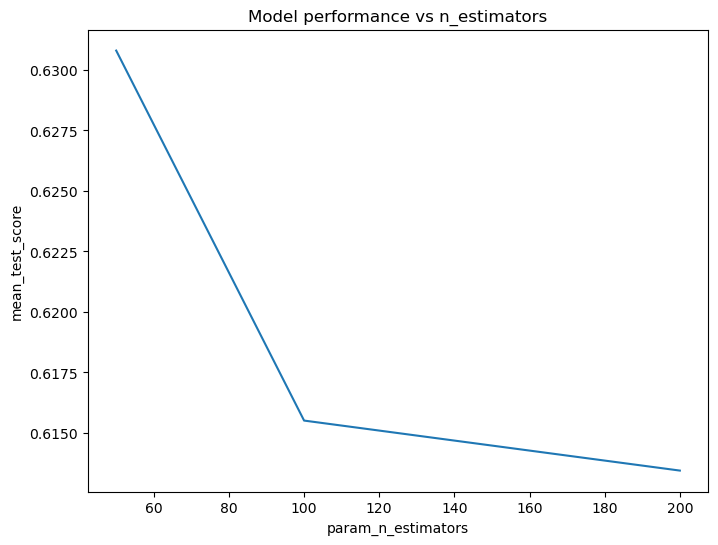

In [91]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=cv_results, x='param_n_estimators', y='mean_test_score', ci=None)
plt.title('Model performance vs n_estimators')
plt.show()

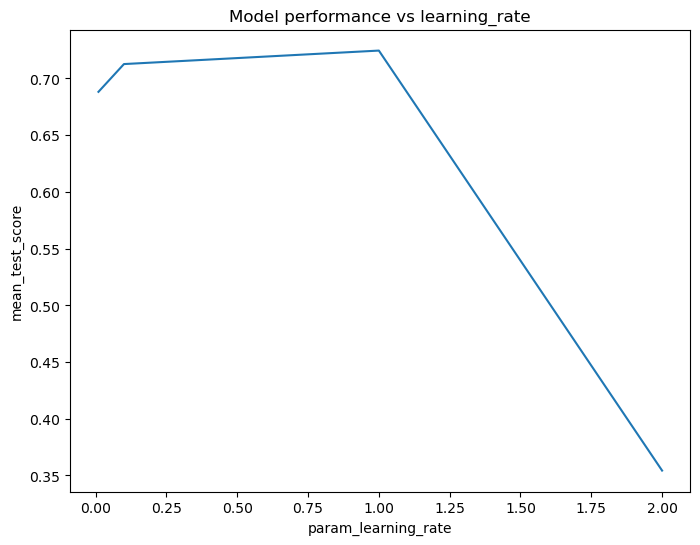

In [92]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=cv_results, x='param_learning_rate', y='mean_test_score', ci=None)
plt.title('Model performance vs learning_rate')
plt.show()

Apply parameters to model and see results of the optimized model.

In [93]:
def train_model(model, params, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    start_time = time.time()
    model.set_params(**params)
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_prec = precision_score(y_train, y_train_pred, average='macro')
    test_prec = precision_score(y_test, y_test_pred, average='macro')

    train_recall = recall_score(y_train, y_train_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')

    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)

    overfit_category = overfitting_category(train_acc, test_acc)

    return model.__class__.__name__, train_time, train_acc, test_acc, train_prec, test_prec, train_recall, test_recall, train_f1, test_f1, train_auc, test_auc, params, overfit_category

In [94]:
model_names = []
train_times = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []
train_aucs = []
test_aucs = [] 
model_params = []
overfit_categories = []

In [95]:
results = train_model(best_ada, best_params, X_train, y_train)
model_names.append(results[0])
train_times.append(results[1])
train_accuracies.append(results[2])
test_accuracies.append(results[3])
train_precisions.append(results[4])
test_precisions.append(results[5])
train_recalls.append(results[6])
test_recalls.append(results[7])
train_f1s.append(results[8])
test_f1s.append(results[9])
train_aucs.append(results[10])
test_aucs.append(results[11])
model_params.append(results[12])
overfit_categories.append(results[13])

In [96]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Train Time': train_times,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Train Precision': train_precisions,
    'Test Precision': test_precisions,
    'Train Recall': train_recalls,
    'Test Recall': test_recalls,
    'Train F1 Score': train_f1s,
    'Test F1 Score': test_f1s,
    'Train AUC': train_aucs,
    'Test AUC': test_aucs,
    'Parameters': model_params,
    'Overfitting Category': overfit_categories
})

In [97]:
results_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters,Overfitting Category
0,AdaBoostClassifier,0.374965,0.729568,0.744325,0.729763,0.746554,0.727505,0.742068,0.727907,0.742311,0.80921,0.818072,"{'algorithm': 'SAMME.R', 'learning_rate': 1.0,...",Acceptable


## XGBoost

In [98]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3,7],
    'min_child_weight': [1, 3],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'n_estimators' : [100, 200],
    'objective': ['binary:logistic']
}

In [99]:
grid = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, verbose=3, n_jobs=-1, cv=5)


In [100]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [101]:
best_xgb = grid.best_estimator_

In [102]:
best_params = grid.best_params_

In [103]:
best_params

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100,
 'objective': 'binary:logistic',
 'subsample': 0.7}

In [104]:
model_names = []
train_times = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []
train_aucs = []
test_aucs = []
model_params = []
overfit_categories = []

In [105]:
results = train_model(best_xgb, best_params, X_train, y_train)
model_names.append(results[0])
train_times.append(results[1])
train_accuracies.append(results[2])
test_accuracies.append(results[3])
train_precisions.append(results[4])
test_precisions.append(results[5])
train_recalls.append(results[6])
test_recalls.append(results[7])
train_f1s.append(results[8])
test_f1s.append(results[9])
train_aucs.append(results[10]) 
test_aucs.append(results[11]) 
model_params.append(results[12])
overfit_categories.append(results[13])

In [106]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Train Time': train_times,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Train Precision': train_precisions,
    'Test Precision': test_precisions,
    'Train Recall': train_recalls,
    'Test Recall': test_recalls,
    'Train F1 Score': train_f1s,
    'Test F1 Score': test_f1s,
    'Train AUC': train_aucs,
    'Test AUC': test_aucs,
    'Parameters': model_params,
    'Overfitting Category': overfit_categories
})

In [107]:
results_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters,Overfitting Category
0,XGBClassifier,0.150203,0.748842,0.746714,0.749652,0.748991,0.746562,0.744461,0.747071,0.744719,0.828389,0.818583,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",Acceptable


Let's optimize n_estimators

In [108]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [109]:
num_boost_round = best_params.pop('n_estimators')

In [110]:
cv_results = xgb.cv(dtrain=dtrain, params=best_params, nfold=3, 
                    num_boost_round=num_boost_round, 
                    early_stopping_rounds=10, metrics="error", 
                    as_pandas=True, seed=123)

In [111]:
n_best_trees = cv_results.shape[0]

In [112]:
print(f"Best number of trees: {n_best_trees}")

Best number of trees: 76


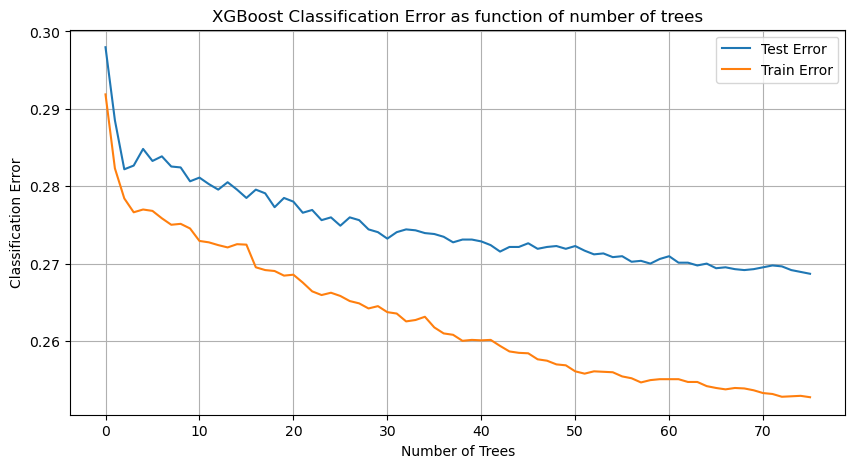

In [113]:
plt.figure(figsize=(10,5))
plt.plot(cv_results.index, cv_results["test-error-mean"], label='Test Error')
plt.plot(cv_results.index, cv_results["train-error-mean"], label='Train Error')
plt.xlabel('Number of Trees')
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error as function of number of trees')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3,7],
    'min_child_weight': [1, 3],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'n_estimators' : range(50, 201, 10),
    'objective': ['binary:logistic']
}

In [115]:
grid = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, verbose=3, n_jobs=-1, cv=5)

In [116]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [117]:
best_params = grid.best_params_

In [118]:
best_params

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 130,
 'objective': 'binary:logistic',
 'subsample': 0.7}

In [119]:
best_xgb = grid.best_estimator_

In [120]:
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=130, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [121]:
from sklearn.model_selection import cross_val_score

In [122]:
train_scores = []
test_scores = []

In [123]:
n_estimators_range = range(50, 201, 10)

Creating a visual of the n_estimators from 50-201 by every 10 to show how we chose the correct n estimators

In [124]:
for n in n_estimators_range:
    model = xgb.XGBClassifier(
        colsample_bytree=0.7,
        learning_rate=0.01,
        max_depth=7,
        min_child_weight=3,
        n_estimators=n,
        objective='binary:logistic',
        subsample=0.7,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    train_cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    train_scores.append(np.mean(train_cv_scores))
    
    test_cv_scores = cross_val_score(model, X_test, y_test, cv=5)
    test_scores.append(np.mean(test_cv_scores))

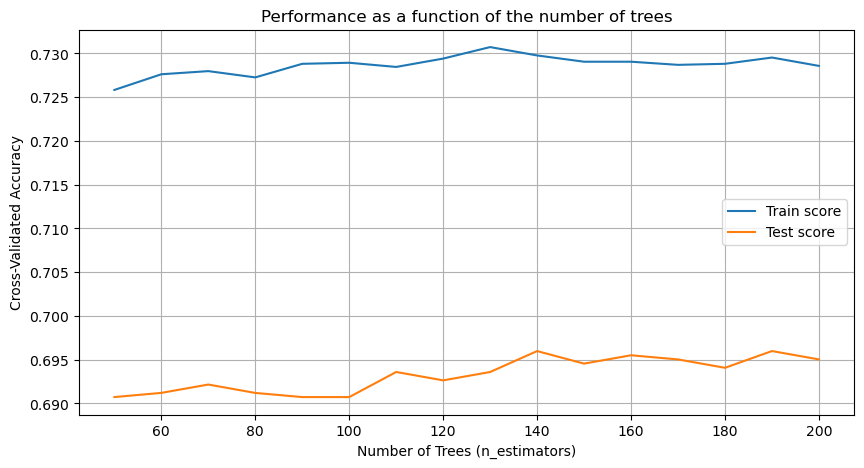

In [125]:
plt.figure(figsize=(10,5))
plt.plot(n_estimators_range, train_scores, label='Train score')
plt.plot(n_estimators_range, test_scores, label='Test score')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Performance as a function of the number of trees')
plt.legend()
plt.grid(True)
plt.show()

In [126]:
model_names = []
train_times = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []
train_aucs = []
test_aucs = []
model_params = []
overfit_categories = []

In [127]:
results = train_model(best_xgb, best_params, X_train, y_train)
model_names.append(results[0])
train_times.append(results[1])
train_accuracies.append(results[2])
test_accuracies.append(results[3])
train_precisions.append(results[4])
test_precisions.append(results[5])
train_recalls.append(results[6])
test_recalls.append(results[7])
train_f1s.append(results[8])
test_f1s.append(results[9])
train_aucs.append(results[10])
test_aucs.append(results[11])
model_params.append(results[12])
overfit_categories.append(results[13])

In [128]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Train Time': train_times,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Train Precision': train_precisions,
    'Test Precision': test_precisions,
    'Train Recall': train_recalls,
    'Test Recall': test_recalls,
    'Train F1 Score': train_f1s,
    'Test F1 Score': test_f1s,
    'Train AUC': train_aucs,
    'Test AUC': test_aucs,
    'Parameters': model_params,
    'Overfitting Category': overfit_categories
})

In [129]:
results_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters,Overfitting Category
0,XGBClassifier,0.357079,0.772001,0.741338,0.773635,0.743568,0.769526,0.739055,0.770184,0.739273,0.857176,0.815527,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",Acceptable


We have optimized this very well.

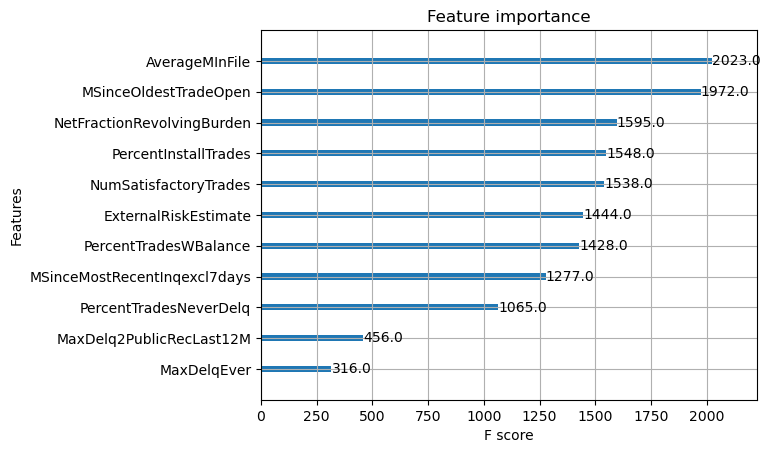

In [130]:
xgb.plot_importance(model)
plt.show()

In [131]:
from sklearn.inspection import plot_partial_dependence

In [132]:
features = [0]

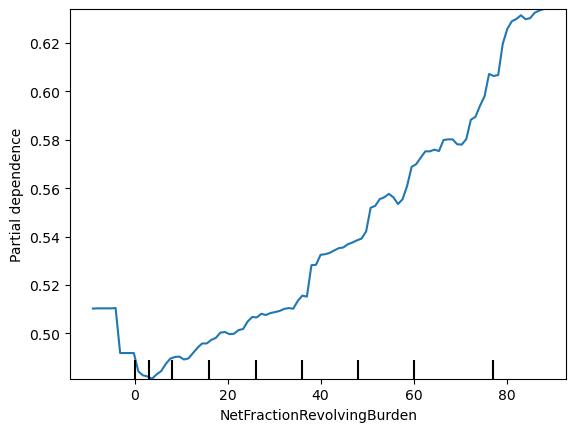

In [133]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [134]:
features = [1]

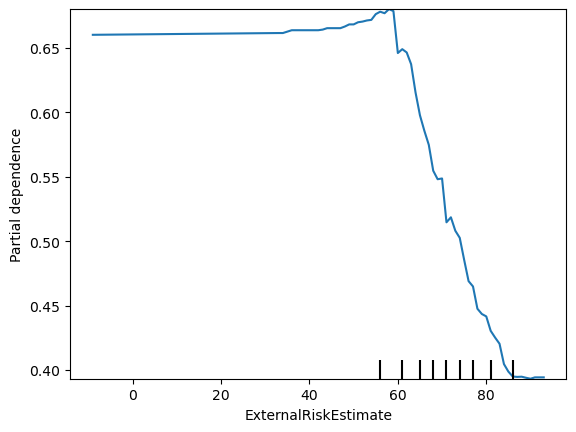

In [135]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [136]:
features = [2]

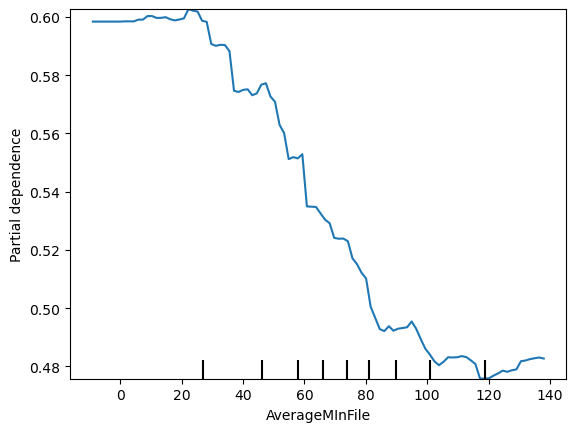

In [137]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [138]:
features = [3]

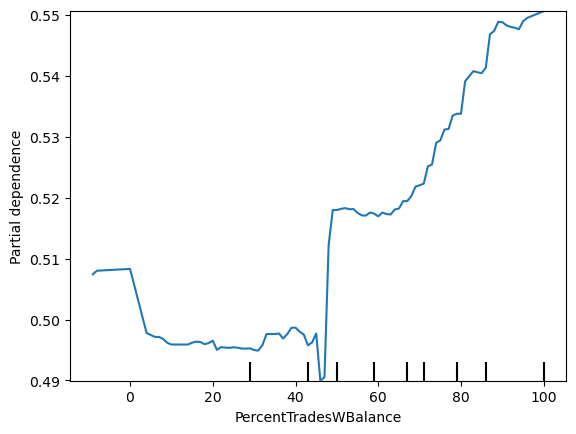

In [139]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [140]:
features = [4]

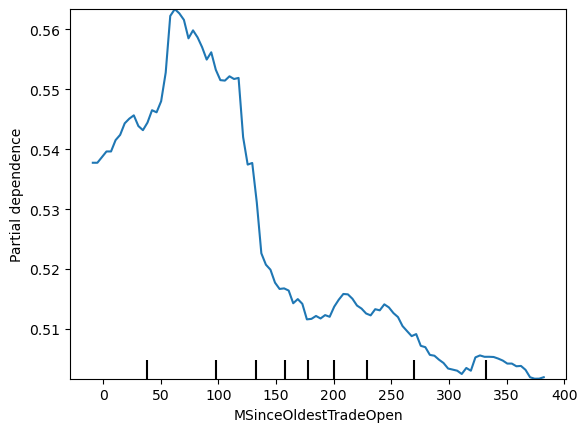

In [141]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [142]:
features = [5]

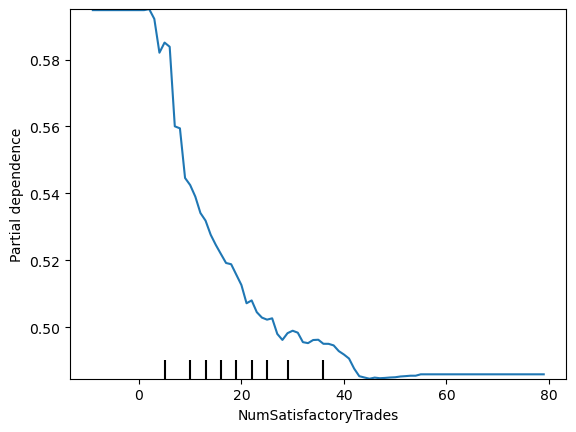

In [143]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [144]:
features = [6]

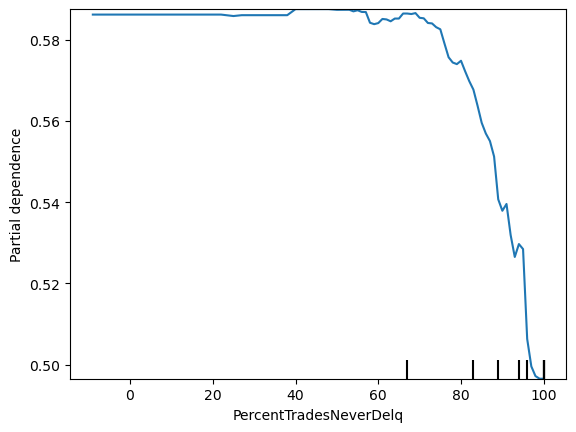

In [145]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [146]:
features = [7]

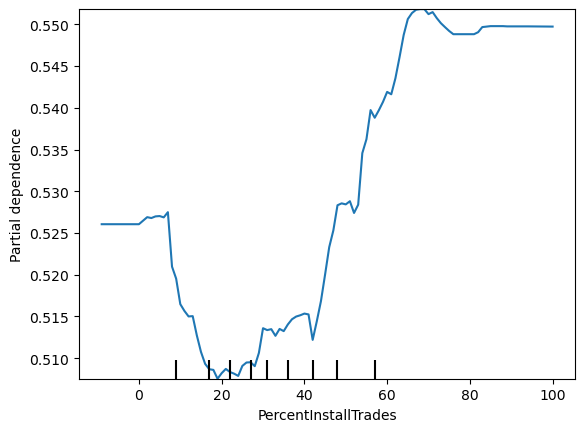

In [147]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [148]:
features = [8]

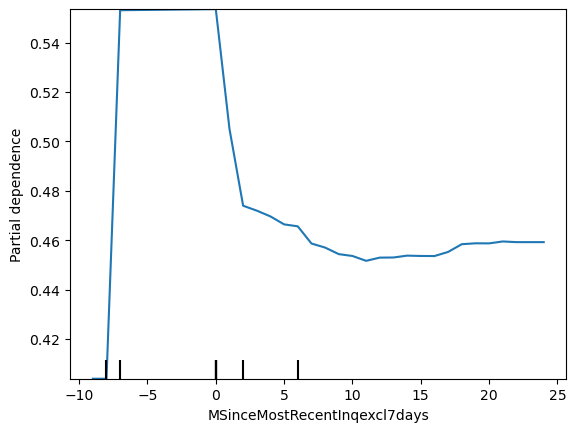

In [149]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [150]:
features = [9]

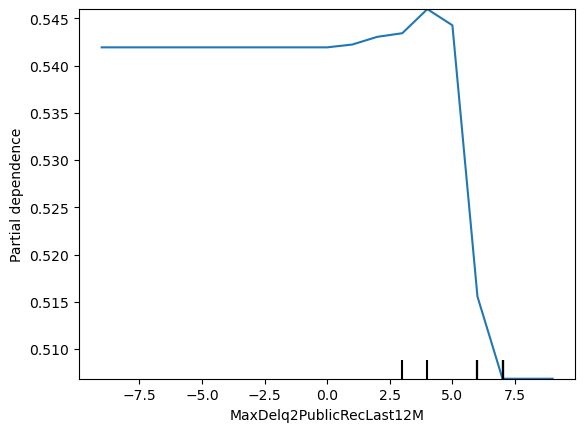

In [151]:
plot_partial_dependence(model, X_train, features)
plt.show()

In [152]:
features = [10]

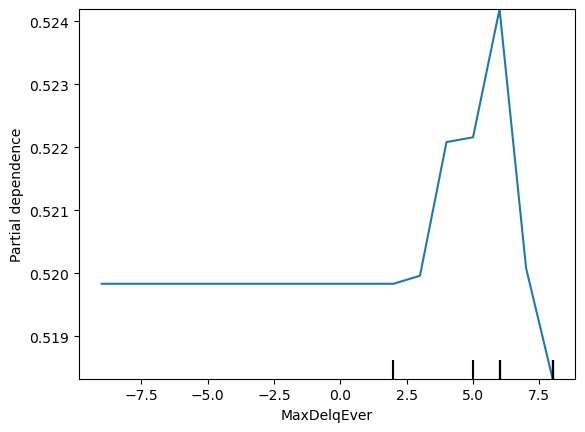

In [153]:
plot_partial_dependence(model, X_train, features)
plt.show()

## Logistic Regression

In [154]:
param_grid = {
    'C': [0.00001,0.0001,0.001, 0.01],
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [1000]
}

In [155]:
logistic = LogisticRegression()

In [156]:
grid_search = GridSearchCV(estimator = logistic, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [157]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vic

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01], 'max_iter': [1000],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             verbose=2)

In [158]:
grid_search.best_params_

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

In [159]:
param_grid = {'C': [0.00001,0.0001,0.001, 0.01, 0.1, 1],
             'max_iter': [1000]}

In [160]:
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [161]:
for metric in scorers.keys():
    print(f"Optimizing for {metric}:")
    
    grid = GridSearchCV(LogisticRegression(), param_grid, scoring=scorers[metric], cv=5)
    grid.fit(X_train, y_train)
    
    print(f"  Best score: {grid.best_score_}")
    print(f"  Best params: {grid.best_params_}\n")

Optimizing for accuracy:
  Best score: 0.6959465857697739
  Best params: {'C': 0.1, 'max_iter': 1000}

Optimizing for precision:
  Best score: 0.7031063716540682
  Best params: {'C': 0.1, 'max_iter': 1000}

Optimizing for recall:
  Best score: 0.7238600849950965
  Best params: {'C': 0.1, 'max_iter': 1000}

Optimizing for f1:
  Best score: 0.7132107925834492
  Best params: {'C': 0.1, 'max_iter': 1000}



In [162]:
model = LogisticRegression(C=0.1, max_iter= 1000)

In [163]:
model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000)

In [164]:
y_train_pred = model.predict(X_train)

In [165]:
y_test_pred = model.predict(X_test)

In [166]:
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

In [167]:
train_auc = roc_auc_score(y_train, y_train_prob)

In [168]:
test_auc = roc_auc_score(y_test, y_test_prob)

In [169]:
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

In [170]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [171]:
print(f"Train accuracy: {train_accuracy}, Test accuracy: {test_accuracy}")
print(f"Train precision: {train_precision}, Test precision: {test_precision}")
print(f"Train recall: {train_recall}, Test recall: {test_recall}")
print(f"Train F1: {train_f1}, Test F1: {test_f1}")
print(f"Train AUC: {train_auc}, Test AUC: {test_auc}")

Train accuracy: 0.6966654714951596, Test accuracy: 0.6658699808795411
Train precision: 0.7036214174627861, Test precision: 0.6786042240587695
Train recall: 0.7245481583161748, Test recall: 0.6792279411764706
Train F1: 0.7139314697926059, Test F1: 0.6789159393661001
Train AUC: 0.7549276570095604, Test AUC: 0.7228974726095617


It doesn't appear that tuning this model is making much of a difference. It's scores are also not as competitive with XGBoost and Adaboost models. I'm going to move on to Neural Network tuning.

## Neural Network

In [172]:
nn_row = results_df_precision[results_df_precision['Model'] == 'Neural Network']

In [173]:
nn_params = nn_row['Parameters'].values[0]

In [174]:
nn_params

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

Going to hyper parameter tune learning rate first. I also am focusing on optimizing based on precision. I will check for overfitting/underfitting after.

In [175]:
from sklearn.neural_network import MLPClassifier

In [176]:
mlp = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    batch_size='auto',
    beta_1=0.9,
    beta_2=0.999,
    early_stopping=False,
    epsilon=1e-08,
    hidden_layer_sizes=(100,),
    learning_rate='constant',
    max_fun=15000,
    max_iter=1000,
    momentum=0.9,
    n_iter_no_change=10,
    nesterovs_momentum=True,
    power_t=0.5,
    random_state=None,
    shuffle=True,
    solver='adam',
    tol=0.0001,
    validation_fraction=0.1,
    verbose=False,
    warm_start=False
)

In [177]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]

In [178]:
param_grid = {'learning_rate_init': learning_rates}

In [179]:
scorer = make_scorer(precision_score, zero_division=1)

In [180]:
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring=scorer)

In [181]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000),
             param_grid={'learning_rate_init': [0.1, 0.01, 0.001, 0.0001]},
             scoring=make_scorer(precision_score, zero_division=1))

In [182]:
best_learning_rate = grid_search.best_params_['learning_rate_init']
best_model = grid_search.best_estimator_

In [183]:
best_learning_rate

0.1

In [184]:
best_model

MLPClassifier(learning_rate_init=0.1, max_iter=1000)

In [185]:
best_model.fit(X_train, y_train)

MLPClassifier(learning_rate_init=0.1, max_iter=1000)

In [186]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [187]:
y_train_prob = best_model.predict_proba(X_train)[:, 1]  # Probability of the positive class for training set
y_test_prob = best_model.predict_proba(X_test)[:, 1]

In [188]:
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

In [189]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [190]:
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

In [191]:
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

In [192]:
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [193]:
results_df = pd.DataFrame({
    'Model': [best_model.__class__.__name__],
    'Train Accuracy': [train_accuracy],
    'Test Accuracy': [test_accuracy],
    'Train Precision': [train_precision],
    'Test Precision': [test_precision],
    'Train Recall': [train_recall],
    'Test Recall': [test_recall],
    'Train F1 Score': [train_f1],
    'Test F1 Score': [test_f1],
    'Train AUC': [train_auc],
    'Test AUC': [test_auc],
    'Parameters': [best_model.get_params()],
})

Seeing about a 1% bump here without overfitting (within 5% of train and text difference)

In [194]:
results_df['Accuracy Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Accuracy'], row['Test Accuracy']), axis=1)
results_df['Precision Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Precision'], row['Test Precision']), axis=1)
results_df['Recall Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Recall'], row['Test Recall']), axis=1)
results_df['F1 Score Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train F1 Score'], row['Test F1 Score']), axis=1)

In [195]:
results_df

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters,Accuracy Overfitting,Precision Overfitting,Recall Overfitting,F1 Score Overfitting
0,MLPClassifier,0.699534,0.672084,0.734411,0.708506,0.665523,0.627757,0.698272,0.665692,0.775873,0.742819,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",Acceptable,Acceptable,Acceptable,Acceptable


Let's mess around with the hidden layers and see if we can accomplish anything there.

In [196]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
hidden_layer_sizes_options = [(100,), (100, 50), (50, 50, 50)]
param_grid = {'learning_rate_init': learning_rates, 'hidden_layer_sizes': hidden_layer_sizes_options}

In [197]:
mlp = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    batch_size='auto',
    beta_1=0.9,
    beta_2=0.999,
    early_stopping=False,
    epsilon=1e-08,
    learning_rate='constant',
    max_fun=15000,
    max_iter=1000,
    momentum=0.9,
    n_iter_no_change=10,
    nesterovs_momentum=True,
    power_t=0.5,
    random_state=None,
    shuffle=True,
    solver='adam',
    tol=0.0001,
    validation_fraction=0.1,
    verbose=False,
    warm_start=False
)

In [198]:
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='precision')

In [199]:
grid_search.fit(X_train, y_train)

/Users/victormcguire/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000),
             param_grid={'hidden_layer_sizes': [(100,), (100, 50),
                                                (50, 50, 50)],
                         'learning_rate_init': [0.1, 0.01, 0.001, 0.0001]},
             scoring='precision')

In [200]:
best_model = grid_search.best_estimator_
best_hyperparameters = grid_search.best_params_
best_precision = grid_search.best_score_

In [201]:
best_model

MLPClassifier(max_iter=1000)

In [202]:
best_hyperparameters

{'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}

In [203]:
best_precision

0.7219712324612277

In [204]:
best_model.fit(X_train, y_train)

MLPClassifier(max_iter=1000)

In [205]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [206]:
y_train_prob = best_model.predict_proba(X_train)[:, 1]  
y_test_prob = best_model.predict_proba(X_test)[:, 1]

In [207]:
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

In [208]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [209]:
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

In [210]:
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

In [211]:
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [212]:
results_df = pd.DataFrame({
    'Model': [best_model.__class__.__name__],
    'Train Accuracy': [train_accuracy],
    'Test Accuracy': [test_accuracy],
    'Train Precision': [train_precision],
    'Test Precision': [test_precision],
    'Train Recall': [train_recall],
    'Test Recall': [test_recall],
    'Train F1 Score': [train_f1],
    'Test F1 Score': [test_f1],
    'Train AUC': [train_auc],
    'Test AUC': [test_auc],
    'Parameters': [best_model.get_params()],
})

In [213]:
results_df['Accuracy Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Accuracy'], row['Test Accuracy']), axis=1)
results_df['Precision Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Precision'], row['Test Precision']), axis=1)
results_df['Recall Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train Recall'], row['Test Recall']), axis=1)
results_df['F1 Score Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train F1 Score'], row['Test F1 Score']), axis=1)
results_df['AUC Overfitting'] = results_df.apply(lambda row: overfitting_category(row['Train AUC'], row['Test AUC']), axis=1)

In [214]:
results_df

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train AUC,Test AUC,Parameters,Accuracy Overfitting,Precision Overfitting,Recall Overfitting,F1 Score Overfitting,AUC Overfitting
0,MLPClassifier,0.681128,0.673518,0.658124,0.653759,0.810798,0.79136,0.726527,0.716008,0.764201,0.721823,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",Acceptable,Acceptable,Acceptable,Acceptable,Acceptable


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.717 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.728 total time=   1.0s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.712 total time=   1.0s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.725 total time=   2.2s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.734 total time=   2.3s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.712 total time=   0.4s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.709 total time=   0.4s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.750 total time=   2.1s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.725 total time=   0.4s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.723 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=20

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.745 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.714 total time=   1.1s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.724 total time=   1.0s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.722 total time=   0.4s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.731 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=10

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.715 total time=   0.4s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.745 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.729 total time=   2.1s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.719 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.726 total time=   1.0s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=20

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.712 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.728 total time=   1.1s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.727 total time=   2.1s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.727 total time=   0.5s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.721 total time=   1.2s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=20

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.718 total time=   0.4s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.720 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.713 total time=   2.1s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.730 total time=   0.4s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.746 total time=   0.4s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=20

[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.714 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.718 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.751 total time=   1.0s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.730 total time=   2.2s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.701 total time=   2.3s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=

[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.709 total time=   0.4s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.713 total time=   0.4s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.724 total time=   1.0s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.748 total time=   2.1s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, objective=binary:logistic, subsample=0.7;, score=0.729 total time=   0.5s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=1

# Findings

By looking at the models outputs. I recommend using XGBoost. IT's scores are a bit higher than the others, it is explainable with the use of Shapley Rates (outside the scope of this class), and is not overfit.

The precision scores ensure that we won't be at risk for defaults outside of what we can plan for. And our recall score will enable us to still offer loans to people that will truly be reliable. 

Therefore since F1 score is a combination of Recall and Precision. All these models, have acceptable overfit scores. Lets see where each falls in that score:

XGBoost F1 Score: 0.7447
AdaBoost F1 Score: 0.7423
Logistic Regression F1 Score: 0.6789
Neural Network F1 Score: 0.6656

We can use the partial dependence plots to explain what is going on with the features used. We do agree with the selection of the feataures based on the correlation scores. 

## Next Steps and Recommendations

The next steps are to see how we can explain the XGBoost model to conform to regulatory requirements. We should alos look deeper into this model and tune it even more. The next steps will be to deploy the model, and observe how the real world data is comparing to the test data. We will see if it is right or wrong, and see what differences in features averages/metrics are coming in as we log it. We will need to give predictions of our predictions to our non-technical stakeholders so this will always be a work in progress.